# Main

In [1]:
"""Scripts for analyzing of phantom outputs.

This script analyze the json files written from the main frame and produce a plot.

"""

'Scripts for analyzing of phantom outputs.\n\nThis script analyze the json files written from the main frame and produce a plot.\n\n'

## Imports & Settings

In [2]:
#%matplotlib inline
import math
import numpy as np
from numpy import pi
#import pandas
from astropy import units
from astropy import constants as const
import matplotlib.pyplot as plt
import matplotlib as mpl
# fix weird moviepy cannot find my ffmpeg exe error
try: from moviepy import editor
except RuntimeError: import os; os.environ["IMAGEIO_FFMPEG_EXE"] = "/usr/bin/ffmpeg"
from moviepy.editor import ImageSequenceClip
from os import path

In [3]:
# import modules listed in ./lib/

import clmuphantomlib as mupl
from clmuphantomlib.io import json_load, hdf5_load
from clmuphantomlib.units_util import set_as_quantity, get_val_in_unit, get_units_field_name, get_units_cgs
from clmuphantomlib.settings import DEFAULT_SETTINGS as settings

    ## import modules in arbitrary directory
    
    #import sys
    
    ## path to my python module lib directory
    ## *** CHECK THIS! *** #
    #SRC_LIB_PATH = sys.path[0] + '/lib'
    
    #if SRC_LIB_PATH not in sys.path:
    #    sys.path.append(SRC_LIB_PATH)
    ##print(*sys.path, sep='\n')    # debug
    #print(
    #    "\n*   Please Make sure my module files are located in this directory (or change the SRC_LIB_PATH variable):",
    #    f"\n{SRC_LIB_PATH = }\n"
    #)

    # parallels & optimizations
    
    
    #import os
    ## Fixing stupid numba killing kernel
    ## See here https://github.com/numba/numba/issues/3016
    #os.environ['NUMBA_DISABLE_INTEL_SVML']  = '1'
    #from numba import njit, prange
    
    
    from multiprocessing import cpu_count, Process, Queue
    
    NPROCESSES = cpu_count()
    if NPROCESSES is None:
        NPROCESSES = 1
    NPROCESSES = max(NPROCESSES, 1)


In [4]:
# settings
#
#   imported from script_input.py file


from script_PhLocAxes__input import verbose, unitsIn, unitsOut, interm_dir, output_dir, fps
from script_PhLocAxes__input import PHOTOSPHERE_TAU, JOB_PROFILES, JOB_PROFILES_GROUPS, JOB_PROFILES_DICT
from _sharedFuncs import mpdf_read

debug_times_yr = (-1., 0.5, 12., 20., 40.)

unitsOutTxt = {  key  : unitsOut[key].to_string('latex_inline') for key in unitsOut.keys() }

tounitsOut  = { unitsType: (1*unitsIn[unitsType]).to_value(unitsOut[unitsType]) for unitsType in unitsOut.keys()}


plt.rcParams.update({'font.size': 20})


# print debug info
if verbose >= 2:
    #print(f"   Note: Will use {NPROCESSES} processes for parallelization")
    pass
    

In [5]:
def get_yval_yerr(
    xval, xerrp, xerrm, xvals, yvals,
) -> (float, float, float):
    """Get y value, error (+), error (-) by interpolating y(x) at x_val."""
    #yval, yerrp, yerrm = get_yval_yerr(xval, xerrp, xerrm, xvals, yvals)
    yval, yerrp_tmp, yerrm_tmp = np.interp((xval, xerrp, xerrm), xvals[::-1], yvals[::-1])
    # yval      = np.interp(xval,  xvals[::-1], yvals[::-1])
    # yerrp_tmp = np.interp(xerrp, xvals[::-1], yvals[::-1])
    # yerrm_tmp = np.interp(xerrm, xvals[::-1], yvals[::-1])
    yerrs = yvals[(xerrm < xvals) & (xvals < xerrp) & np.isfinite(yvals)]
    if len(yerrs) >= 1:
        yerrs = [np.max(yerrs), np.min(yerrs)]
    else:
        yerrs = []
    if not np.isfinite(yerrp_tmp):
        yerrs.append(yerrp_tmp)
    if not np.isfinite(yerrm_tmp):
        yerrs.append(yerrm_tmp)
    if len(yerrs) >= 2:
        yerrp, yerrm = np.max(yerrs), np.min(yerrs)
    else:
        yerrp, yerrm = np.nan, np.nan
    return yval, yerrp, yerrm

In [6]:
def get_yval_yerr_array(
    xval, xerrp, xerrm, xvals, yvals,
) -> (np.ndarray, np.ndarray, np.ndarray):
    """"Get y value, error (+), error (-) by interpolating y(x) at x_val, array edition.

    xval  is (nx,)-shaped 1D array.
    xvals is (nx,)-shaped 1D array.
    etc.
    """
    yval = np.zeros_like(xval)
    yerrp = np.zeros_like(yval)
    yerrm = np.zeros_like(yval)
    for i in range(len(xval)):
        yval[i], yerrp[i], yerrm[i] = get_yval_yerr(xval[i], xerrp[i], xerrm[i], xvals, yvals)
    return yval, yerrp, yerrm

# Analysis

In [7]:
job_profile = JOB_PROFILES_DICT['2md']
job_profile

{'raw_dir': '../raw/luis_2md/',
 'file_prefix': 'light',
 'file_indexes': array([    0,    20,    40,    60,    80,   100,   120,   140,   160,
          180,   200,   220,   240,   260,   280,   300,   320,   340,
          360,   380,   400,   420,   440,   460,   480,   500,   520,
          540,   560,   580,   600,   620,   640,   660,   680,   700,
          720,   740,   760,   780,   800,   820,   840,   860,   880,
          900,   920,   940,   960,   980,  1000,  1020,  1040,  1060,
         1080,  1100,  1120,  1140,  1160,  1180,  1200,  1220,  1240,
         1260,  1280,  1300,  1320,  1340,  1360,  1380,  1400,  1420,
         1440,  1460,  1480,  1500,  1520,  1540,  1560,  1580,  1600,
         1620,  1640,  1660,  1680,  1700,  1720,  1740,  1760,  1780,
         1800,  1820,  1840,  1860,  1880,  1900,  1920,  1940,  1960,
         1980,  2000,  2020,  2040,  2060,  2080,  2100,  2120,  2140,
         2160,  2180,  2200,  2220,  2240,  2260,  2280,  2300,  2320,
    

In [8]:
eos_opacity = mupl.eos.mesa.EoS_MESA_opacity(job_profile['params'], settings)
mpdf = mpdf_read(job_profile['job_name'], 4800, eos_opacity=eos_opacity)
kernel = mpdf.data['gas'].kernel
col_kernel = kernel.get_column_kernel_func(samples=1000)
kc_1pt = col_kernel(0, 3)
print(f"{kc_1pt = }")

*   Note   :    <module>() ==> mpdf_read() ==> read():
	

	Reading filename='../raw/luis_2md/light_04800'


*   Note   :    mpdf_read() ==> read() ==> reset_xyz_by():
	Reseting Origin to CoM ([-1.84273874  3.15201014 -0.71579591])...
*   Note   :    mpdf_read() ==> read() ==> reset_xyz_by():
	CoM location is now [-8.62880176e-14 -5.23891536e-14  6.16342983e-15]
**  Warning:    <module>() ==> mpdf_read() ==> read():
	kappa column exists.
	We here assume kappa is in phantom units self.units['opacity']=Unit("udist2 / umass") 
	However in phantom kappa is assumed to be in cgs unit.
	If so, please CONVERT KAPPA MANNUALLY into PHANTOM units BEFORE proceeding, e.g.:
		mpdf.data['gas']['kappa'] = mupl.units_util.get_val_in_unit(
		mpdf.data['gas']['kappa'], units.cm**2/units.g, mpdf.units['opacity'])
kc_1pt = 0.4774648292758465


In [9]:
#JOB_PROFILES_GROUPS['2m'] = (JOB_PROFILES[0], JOB_PROFILES[4])    # using the old miguel 2Msun sim (without new relaxation method)

In [10]:
do_debug = True
if __name__ == '__main__':
    from script_PhLocAxes__input import JOB_PROFILES
    if do_debug:
        pass
        # JOB_PROFILES_COPY = JOB_PROFILES
        # JOB_PROFILES = [job_profile.copy() for job_profile in JOB_PROFILES_COPY[2:]]
        #for job_profile in JOB_PROFILES:
        #    job_profile['file_indexes'] = [job_profile['file_indexes'][-1]]

In [19]:
raise NotImplementedError("Savefile format changed from json to hdf5 in main script, but this one hasn't been altered to load it")

NotImplementedError: Savefile format changed from json to hdf5 in main script, but this one hasn't been altered to load it

## Photosphere size vs time

Debug:  ../photosphere/luis_2md/light
times_yr_inds  : [ 0.          0.75752451  1.26254085  1.51504902  1.76755719  2.02006536
  2.27257353  2.5250817   2.77758987  3.03009804  3.28260621  3.53511438
  3.78762255  4.04013072  4.29263889  4.54514706  4.79765523  5.0501634
  5.30267157  5.55517974  5.80768791  6.06019608  6.31270425  6.56521241
  6.81772058  7.07022875  7.32273692  7.57524509  8.08026143  8.3327696
  8.58527777  8.83778594 20.        ]
orbseps_au_inds: [2.55867612 2.52983458 2.50335881 2.42630296 2.32112199 2.19230499
 2.0513716  1.92428489 1.82509168 1.72966339 1.60836411 1.41919068
 1.16432636 0.94791105 0.80993795 0.61982267 0.53260373 0.43290011
 0.32394156 0.2780844  0.2466206  0.23228086 0.22093317 0.21850803
 0.21001657 0.20400841 0.20153979 0.20144038 0.2013519  0.19878127
 0.19523764 0.19290429 0.19290236]
time=0.0, y=2.1221077526421954, y_err=0.2526670108359509
    y_data_xypm=array([2.14482753, 2.09038333, 2.0925139 , 2.11117671, 2.14513409,
       2.14773799

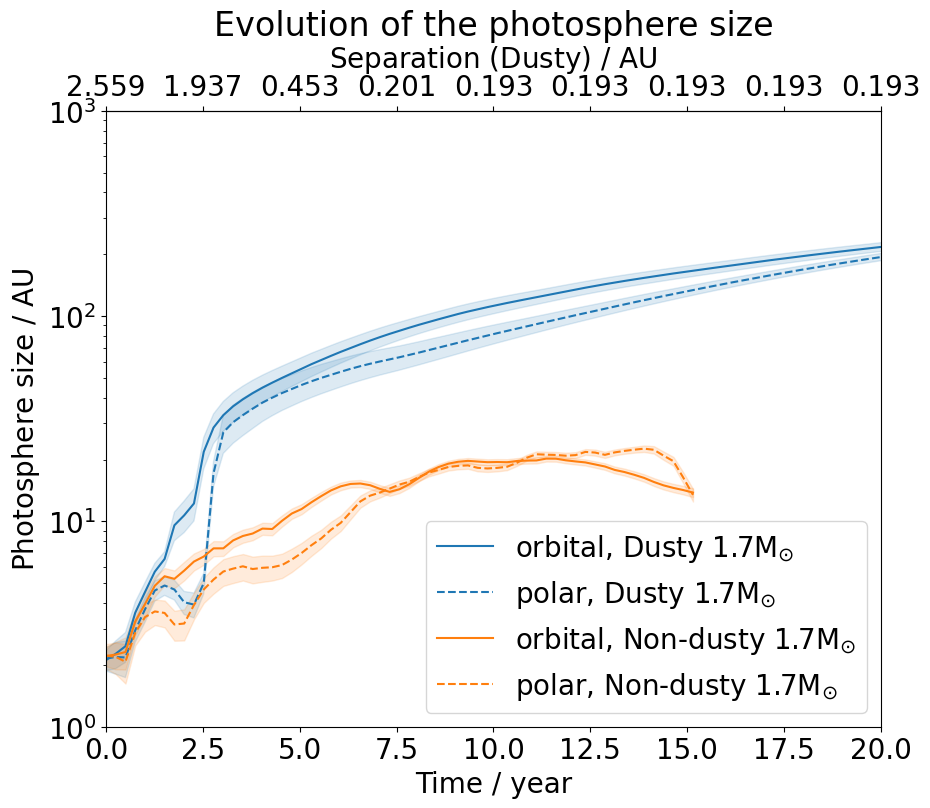

Debug:  ../photosphere/luis_4md/light
times_yr_inds  : [ 0.          0.25250817  0.50501634  1.01003268  1.26254085  1.51504902
  1.76755719  2.02006536  2.27257353  2.5250817   2.77758987  3.03009804
  3.28260621  3.53511438  3.78762255  4.04013072  4.29263889  4.54514706
  4.79765523  5.0501634   5.30267157  5.55517974  5.80768791  6.06019608
  6.31270425  6.56521241  6.81772058  7.07022875  7.32273692  7.57524509
  8.08026143  8.83778594  9.59531045 11.86788398 12.12039215 12.37290032
 13.63544117 14.89798202 20.        ]
orbseps_au_inds: [2.96341217 2.96286731 2.9579851  2.95153536 2.89376004 2.86035093
 2.82791578 2.78154471 2.71988305 2.64211765 2.55873554 2.47335158
 2.38042473 2.26283634 2.11166654 1.91524545 1.64491999 1.26009846
 0.8977833  0.44049424 0.26949729 0.15726407 0.1103882  0.08807392
 0.07649083 0.07300434 0.06868083 0.06280955 0.06264555 0.05837203
 0.05714545 0.05614853 0.05579529 0.05572647 0.05462643 0.05460694
 0.05447001 0.05442068 0.05442013]
time=0.0, y=2.2

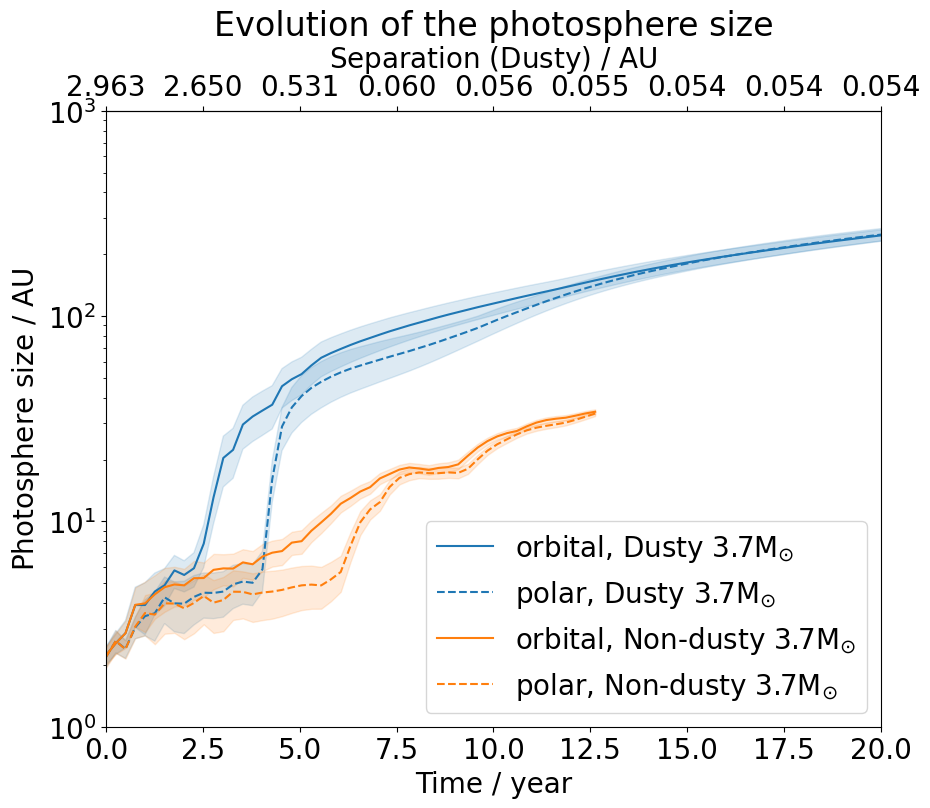

In [40]:
if __name__ == '__main__':

    # plotting

    #keys = rays_dir.keys()
    ylim = (1., 1000.)
    #x_use = 'time'
    
    xlims = {
        '2m': (0., 20.),
        '4m': (0., 20.),
    }
    color_dict = {
        '2md': 'C0',
        '4md': 'C0', #'C0',
        '2m' : 'C1',
        '2m_2022': 'C1', #'C1',
        '4m' : 'C1', #'C1',
    }

    groups_dict = {
        '2m' : ['2md', '2m_2022'],
        '4m' : ['4md', '4m'],
    }
    
    
    for group_name in groups_dict.keys(): #JOB_PROFILES_GROUPS.keys():
    
    
        fig, ax = plt.subplots(figsize=(10, 8))
        xlim = xlims[group_name]
        
        for i, job_nickname in enumerate(groups_dict[group_name]): #enumerate(JOB_PROFILES_GROUPS[group_name]):
            job_profile = JOB_PROFILES_DICT[job_nickname]
            job_name = job_profile['job_name']
            color    = color_dict[job_profile['nickname']]
            with open(f"{job_name}__photospherePars__xyz.json", 'r') as f:
                photosphere_pars = json_load(f)
            
    
            times_yr = np.array(photosphere_pars['time_yr'])
            orbseps_au = np.array(photosphere_pars['orbsep_Rsun']) * tounitsOut['dist']
            x = times_yr
            
            if i == 0:
                # getting funcs for 2nd x axis transform, and
                # making sure orbseps_au is mono-decreasing, so np.interp doesn't freak out
                orbsep_tempmin = orbseps_au[0]
                x_inds = [0]
                for i in range(len(orbseps_au)):
                    if orbsep_tempmin > orbseps_au[i]:
                        orbsep_tempmin = orbseps_au[i]
                        x_inds.append(i)
                times_yr_inds   = times_yr[x_inds].copy()
                orbseps_au_inds = orbseps_au[x_inds].copy()
                if xlim[1] > times_yr_inds[-1]:
                    # add an end point so the secondary xaxis labels of orbsep does not freak out
                    times_yr_inds   = np.append(times_yr_inds, xlim[1])
                    orbseps_au_inds = np.append(orbseps_au_inds, orbseps_au_inds[-1]*(1.-1e-5))
                functions = (
                    lambda x: np.interp(x, times_yr_inds, orbseps_au_inds),
                    lambda x: np.interp(x, orbseps_au_inds[::-1], times_yr_inds[::-1]),
                )
                if verbose >= 3:
                    print(f"Debug:  {job_name}\ntimes_yr_inds  : {times_yr_inds}\norbseps_au_inds: {orbseps_au_inds}")
                
                
            y_data_xypm     = np.array([photosphere_pars['data'][key]['size'] for key in ('+x', '-x', '+y', '-y',)])
            y_err_data_xypm = np.array([photosphere_pars['data'][key]['h'] for key in ('+x', '-x', '+y', '-y',)])
            y     = np.average(    y_data_xypm**2, axis=0)**0.5 * tounitsOut['dist']
            y_err = np.average(y_err_data_xypm**2, axis=0)**0.5 * tounitsOut['dist']
    
            ax.semilogy(x, y, '-', color=color, label=f"orbital, {job_profile['name']}")    
            ax.fill_between(x, y-y_err, y+y_err, color=color, alpha=0.15)
            if verbose >= 4:
                print(f"Photosphere size(orbital):\n time(yr): size({unitsOutTxt['dist']})\n{ {x_i : y_i for x_i, y_i in zip(x, y)} }")
            
            
            y_data_zpm     = np.array([photosphere_pars['data'][key]['size'] for key in ('+z', '-z',)])
            y_err_data_zpm = np.array([photosphere_pars['data'][key]['h'] for key in ('+z', '-z',)])
            y     = np.average(    y_data_zpm**2, axis=0)**0.5 * tounitsOut['dist']
            y_err = np.average(y_err_data_zpm**2, axis=0)**0.5 * tounitsOut['dist']
    
            ax.semilogy(x, y, '--', color=color, label=f"polar, {job_profile['name']}")
            ax.fill_between(x, y-y_err, y+y_err, color=color, alpha=0.15)
            if verbose >= 4:
                print(f"Photosphere size(polar):\n time(yr): size({unitsOutTxt['dist']})\n{ {x_i : y_i for x_i, y_i in zip(x, y)} }")

            if verbose >= 3:
                for debug_time_yr in debug_times_yr:
                    debug_inds = np.where(np.array(photosphere_pars['time_yr']) > debug_time_yr)[0]
                    if len(debug_inds):
                        debug_ind = debug_inds[0]
                        all_axes_names = ('+x', '-x', '+y', '-y', '+z', '-z')
                        time = photosphere_pars['time_yr'][debug_ind]
                        y_data_xypm     = np.array([photosphere_pars['data'][key]['size'][debug_ind] for key in all_axes_names]
                                                  ) * tounitsOut['dist']
                        y_err_data_xypm = np.array([photosphere_pars['data'][key]['h'][debug_ind] for key in all_axes_names]
                                                  ) * tounitsOut['dist']
                        y     = np.average(    y_data_xypm**2, axis=0)**0.5
                        y_err = np.average(y_err_data_xypm**2, axis=0)**0.5
                        print(f"{time=}, {y=}, {y_err=}\n    {y_data_xypm=}\n    {y_err_data_xypm=}")
                    
            
    
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_xlabel("Time / year")
        ax.set_ylabel(f"Photosphere size / {unitsOutTxt['dist']}")
        
        secax = ax.secondary_xaxis('top', functions=functions)
        secax.set_xlabel(f"Separation (Dusty) / {unitsOutTxt['dist']}")
        secax.set_ticks(functions[0](ax.get_xticks()))
        #secax.set_ticks(ax.get_xticks())
        
        #ax.text(
        #    0.98, 0.98,
        #    f"$\\mu = {mu} $",
        #    color = "black", ha = 'right', va = 'top',
        #    transform=ax.transAxes,
        #)
        ax.legend(loc="lower right")
        ax.set_title("Evolution of the photosphere size")# + f"resolution = {mpdf.params['nparttot']:.2e}",)
    
    
        outfilename_x = 't+sep'
        outfilename_noext = f"fig__{group_name}__photosphereSize-{outfilename_x}__xyz"
        fig.savefig(f"{outfilename_noext}.pdf")
        fig.savefig(f"{outfilename_noext}.png")
        plt.show()
        plt.close(fig)

## Temp vs Rad plots

#### Debug

In [ ]:
# Temp vs Rad plots

if __name__ == '__main__':

    # settings
    xlim = (1e-1, 2e3)
    if do_debug:
        unitsOut['dist']=units.Rsun
        unitsOutTxt['dist'] = unitsOut['dist'].to_string('latex_inline')
        xlim = (8000, 20000)
    # labels = ['+x']    # name of the ray to be plotted
    label  = '+x'      # name of the ray to be plotted
    quans  = ['tau', 'kc', 'T', 'rho', 'h']    # quantities to be plotted
    ylims  = {
        'tau': (5e-6, 5e5),
        'kc' : (1e-4, 1e2),
        'rho': (5e-20, 5e-6), # None
        'h'  : (1e0, 1e4),
        'T'  : (1e1, 5e5),
        'kappa': (1e-5, 1e3),
        'vr' : (5e-1, 2e2),
    }
    ylabels = {
        'tau': "\\tau",
        'kc' : "\\int_{z}^{+\infty} w(q_{ik}(z')) dz'",
        'rho': "\\rho",
        'h'  : "h",
        'T'  : "T",
        'kappa': "\\kappa",
        'vr' : "{v_r}",
    }
    

    # plotting
    i = 0    # index of ray - do not change
    for job_nickname in ['2md']: #['2m_2022', '4m', '2md', '4md']:
        job_profile  = JOB_PROFILES_DICT[job_nickname]
        job_name     = job_profile['job_name']
        #job_nickname = job_profile['nickname']
        outfilenames = []
        for file_index in [2000,] if do_debug else job_profile['file_indexes']:
            # load data
            infilename = f"{interm_dir}{job_nickname}_{file_index:05}.photospherePars.xyz.hdf5"
            if verbose: print(f"\nWorking on {infilename}... ", end='')
            photosphere_pars = hdf5_load(infilename)
        
            time = set_as_quantity(photosphere_pars['time_yr'], units.yr)
            #orbsep_Rsun = np.array(photosphere_pars['orbsep_Rsun'])

        
            fig, axes = plt.subplots(len(quans), figsize=(16, 2+4*len(quans)), squeeze=False, sharex=True)
            fig.subplots_adjust(hspace=0.0, wspace=0.0)

            xerrs_dict = {}
            photosphere = photosphere_pars['data'][label]
            xval  = get_val_in_unit(photosphere['R1'       ], unitsIn['dist'], unitsOut['dist'])
            xerr  = get_val_in_unit(photosphere['h'        ], unitsIn['dist'], unitsOut['dist'])
            xvals = get_val_in_unit(photosphere['R1_on_ray'], unitsIn['dist'], unitsOut['dist'])
            xerrs = get_val_in_unit(photosphere[ 'h_on_ray'], unitsIn['dist'], unitsOut['dist'])
            xerrs_dict[label] = (xval, xerr, xvals)
            
            xvals_pts = get_val_in_unit(photosphere['Rt_at_pts'], unitsIn['dist'], unitsOut['dist'])
            xerrs_pts = get_val_in_unit(photosphere[ 'h_at_pts'], unitsIn['dist'], unitsOut['dist'])

            R1_kc_eq1 = np.interp(   1.0, photosphere['kc_on_ray'], photosphere['R1_on_ray'])
            R1_kc_1pt = np.interp(kc_1pt, photosphere['kc_on_ray'], photosphere['R1_on_ray'])

            masks_pts = xvals_pts < R1_kc_eq1
                
                
            for ax, quan in zip(axes, quans):
                ax = ax[0]
                ylim = ylims[quan] if quan in ylims.keys() else None
                ylabel = ylabels[quan] if quan in ylabels.keys() else None
                unit_name = get_units_field_name(quan) if quan not in {'kc'} else 'dimless'
                valtxts = []
                yvaltxt_logs = []
                yerrs_dict = {}

                photosphere = photosphere_pars['data'][label]
                xval, xerr, xvals = xerrs_dict[label]
                xerrp = xval + xerr
                xerrm = xval - xerr

                yvals = get_val_in_unit(photosphere[f'{quan}_on_ray'], unitsIn[unit_name], unitsOut[unit_name])
                yval, yerrp, yerrm = get_yval_yerr(xval, xerrp, xerrm, xvals, yvals)
                dyerrp = yerrp - yval
                dyerrm = yerrm - yval
                # store it for later because we want them to be on the same scale for +x and +z
                yerrs_dict[label] = (yval, dyerrp, dyerrm)

                # interpolated results
                ax.loglog(xvals, yvals, color=f'C{i}', label=label)
                # pts
                if quan not in {'kc'}:
                    yvals_pts = get_val_in_unit(photosphere[f'{quan}_at_pts'], unitsIn[unit_name], unitsOut[unit_name])
                    _, yerrps_pts, yerrms_pts = get_yval_yerr_array(
                        # xvals_pts, xvals_pts+xerrs_pts, xvals_pts-xerrs_pts, xvals, yvals,
                        xvals_pts, xvals_pts+xerrs_pts, xvals_pts-xerrs_pts, xvals, yvals
                    )
                    yerrs_pts = np.vstack((yvals_pts - yerrms_pts, yerrps_pts - yvals_pts))
                    yerrs_pts = np.where(yerrs_pts < 0, 0, yerrs_pts)
                    mk = masks_pts
                    ax.errorbar(
                        xvals_pts[mk], yvals_pts[mk],
                        xerr=xerrs_pts[mk], yerr=yerrs_pts[:, mk],
                        fmt='o', color=f'C{i}', ecolor=f'C{i+1}', errorevery=32,
                        label="pts, S counted",
                    )
                    ax.errorbar(
                        xvals_pts[~mk], yvals_pts[~mk],
                        xerr=xerrs_pts[~mk], yerr=yerrs_pts[:, ~mk],
                        fmt='o', color=f'C{i+2}', ecolor=f'C{i+1}', errorevery=32,
                        label="pts, S ignored",
                    )
                
                ax.set_xlim(xlim)
                ax.set_ylim(ylim)
                ax.fill_betweenx(
                    ax.get_ylim(),
                    get_val_in_unit(photosphere['R1'] - photosphere['h'], unitsIn['dist'], unitsOut['dist']),
                    get_val_in_unit(photosphere['R1'] + photosphere['h'], unitsIn['dist'], unitsOut['dist']),
                    color=f'C{i}', alpha=0.1)
                ax.set_ylabel(f"${ylabel}$ / {unitsOutTxt[unit_name]}" if unit_name != 'dimless' else f"${ylabel}$")
                if quan == 'tau':
                    ax.axhline(PHOTOSPHERE_TAU, color='grey', linestyle='dashed')
                elif quan == 'kc':
                    ax.axhline(1.0, color=f'C{i+2}', linestyle='dotted')
                    # note: kc_1pt should be approx 0.4774648292758465 for normal kernel
                    ax.axhline(kc_1pt, color=f'C{i+1}', linestyle='dotted')
                    
                ax.axvline(photosphere['R1'], color='grey', linestyle='dashed')
                ax.axvline(R1_kc_eq1, color=f'C{i+2}', linestyle='dashed')
                ax.axvline(R1_kc_1pt, color=f'C{i+1}', linestyle='dashed')

                # get the scale of the value for the exact val & err text
                try:
                    yvaltxt_log = np.log10(np.abs([yval, dyerrm, dyerrp]))
                    yvaltxt_log = int(np.floor(np.average(yvaltxt_log[np.isfinite(yvaltxt_log)])))
                    if quan in ['tau', 'T', 'vr']:
                        # mannual override
                        yvaltxt_log = 0
                except ValueError:
                    yvaltxt_log = 0
                yvaltxt_logs.append(yvaltxt_log)


                # get val text
                
                # init
                yvaltxt_log = min(yvaltxt_logs)
                yval, dyerrp, dyerrm = yerrs_dict[label]
                
                # ignore small scales
                if yvaltxt_log == 1: yvaltxt_log = 0
                    
                yvaltxt  = f"${ylabel}_{{{label}}} ="
                yvaltxt += f"{yval/10**yvaltxt_log:.1f}^{{{dyerrp/10**yvaltxt_log:+.1f}}}_{{{dyerrm/10**yvaltxt_log:+.1f}}}$"
                if yvaltxt_log != 0: yvaltxt += f" $10^{{{yvaltxt_log}}}$"
                yvaltxt += f" {unitsOutTxt[unit_name]}"
                yvaltxt += f" ({(abs(dyerrp)+abs(dyerrm))/yval/2:.0%})"
                
                valtxts.append(yvaltxt)
                    
                ax.text(xlim[0], ylim[0], '\n'.join(valtxts), ha='left', va='bottom')
                
            ax.set_xlabel(f"$R_1$ / {unitsOutTxt['dist']}")
            ax.legend(loc='upper right')

            # set title and time label
            ax = axes[0][0]
            ax_txts = [f"Time = {time:.1f}"]

            xval, xerr, _ = xerrs_dict[label]
            ax_txts.append(f"$R_{{1, \\mathrm{{{label}, ph}}}} = {xval:.1f} \\pm {xerr:.1f}$ {unitsOutTxt['dist']}")
        
            ax.text(
                0.98, 0.98,
                '\n'.join(ax_txts),
                color = "black", ha = 'right', va = 'top',
                transform=ax.transAxes,
            )
            ax.set_title(
                f"Properties along one singe ray\n" + \
                #f"resolution = {photospheres['dump_info']['nparttot']:.2e}\n" + \
                f"{job_profile['plot_title_suffix']}",
            )
            
            # if do_debug and np.any([ph['is_found'] for _, ph in photosphere_pars['data'].items()]):
            #     # OVERRIDE X LIMIT
            #     ax.set_xlim(
            #         np.nanmin([ph['R1'] - ph['h']*2 for _, ph in photosphere_pars['data'].items()]),
            #         np.nanmax([ph['R1'] + ph['h']*2 for _, ph in photosphere_pars['data'].items()]),
            #     )
                
            # save fig
            outfilename = f"{output_dir}{job_nickname}_{file_index:05d}__singleRayProperties.png"
            outfilenames.append(outfilename)
            fig.savefig(outfilename)
            plt.close(fig)
            if verbose: print(f"Done.\n")

        # define job_folder_prefix
        for i in range(len(job_name)-1, -1, -1):
            if job_name[i] == path.sep:
                job_folder_prefix = job_name[:i]
                break
            else:
                job_folder_prefix = job_name
        with ImageSequenceClip(outfilenames, fps=fps) as vid:
            moviefilename = f"{output_dir}{job_nickname}__singleRayProperties__movie.mp4"
            vid.write_videofile(moviefilename)

    if verbose: print("\n\n\n*** All Done. ***\n\n\n")

In [125]:
np.count_nonzero(np.isnan(yerrs_pts))

9258

In [12]:
eos

NameError: name 'eos' is not defined

In [118]:
yerrs_dict

{'+x': (np.float64(0.6666666666666659),
  array([ 1.68041134e+01,  1.68041134e+01,  1.68041134e+01, ...,
         -1.14298127e+09, -1.14298127e+09, -1.14298127e+09]),
  array([ 4.32111966e-04,  4.32111966e-04,  4.32111966e-04, ...,
         -1.14298128e+09, -1.14298128e+09, -1.14298128e+09]))}

In [117]:
dyerrm

array([ 4.32111966e-04,  4.32111966e-04,  4.32111966e-04, ...,
       -1.14298128e+09, -1.14298128e+09, -1.14298128e+09])

In [113]:
dyerrp/10**yvaltxt_log

array([ 1.68041134e+01,  1.68041134e+01,  1.68041134e+01, ...,
       -1.14298127e+09, -1.14298127e+09, -1.14298127e+09])

In [110]:
xerrs_pts.shape

(4358,)

In [106]:
yerrs.shape

(2, 4096)

In [107]:
yvals.shape

(4096,)

In [97]:
np.vstack((yerrm, yerrp))

array([[ 56.97262679,  56.97262679,  56.97262679, ...,  56.97262679,
         56.97262679,  56.97262679],
       [169.18603753, 169.18603753, 169.18603753, ..., 169.18603753,
        169.18603753, 169.18603753]])

In [87]:
get_yval_yerr(xvals[1000], xerrp, xerrm, xvals, yvals)

(np.float64(140.75965414877157),
 np.float64(169.1860375314287),
 np.float64(56.9726267938292))

In [89]:
yval, yerrp, yerrm = get_yval_yerr_array(xvals, xerrp, xerrm, xvals, yvals)
yval, yerrp, yerrm

(array([inf, inf, inf, ..., inf, inf, inf]),
 array([169.18603753, 169.18603753, 169.18603753, ..., 169.18603753,
        169.18603753, 169.18603753]),
 array([56.97262679, 56.97262679, 56.97262679, ..., 56.97262679,
        56.97262679, 56.97262679]))

<ErrorbarContainer object of 3 artists>

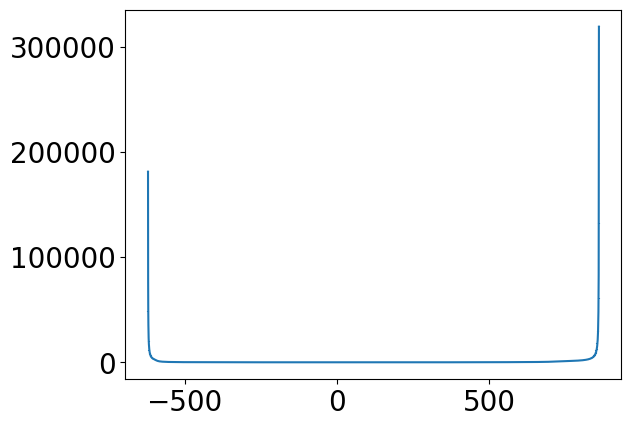

In [92]:
plt.errorbar(xvals, yval, yerr = yerrp)

In [54]:
yerrm, yerrp

(np.float64(56.9726267938292), np.float64(169.1860375314287))

In [49]:
R1_kc_1pt

np.float64(976.8830229049389)

In [51]:
photosphere['kc_on_ray']

array([  0.        ,   0.        ,   0.        , ..., 365.62320809,
       365.62320809, 365.62320809])

#### Run


Working on ../interm/2md_00000.photospherePars.xyz.json...
Saved to ../fig/20241212_photosphere-axes_v-vs-R1/2md_00000__singleRayProperties.png.
Saved to ../fig/20241212_photosphere-axes_v-vs-R1/2md_00000__singleRayProperties.pdf.

Working on ../interm/2md_01200.photospherePars.xyz.json...
Saved to ../fig/20241212_photosphere-axes_v-vs-R1/2md_01200__singleRayProperties.png.
Saved to ../fig/20241212_photosphere-axes_v-vs-R1/2md_01200__singleRayProperties.pdf.

Working on ../interm/2md_04800.photospherePars.xyz.json...
Saved to ../fig/20241212_photosphere-axes_v-vs-R1/2md_04800__singleRayProperties.png.
Saved to ../fig/20241212_photosphere-axes_v-vs-R1/2md_04800__singleRayProperties.pdf.

Working on ../interm/2md_17600.photospherePars.xyz.json...
Saved to ../fig/20241212_photosphere-axes_v-vs-R1/2md_17600__singleRayProperties.png.
Saved to ../fig/20241212_photosphere-axes_v-vs-R1/2md_17600__singleRayProperties.pdf.

Working on ../interm/4md_00000.photospherePars.xyz.json...
Saved to ../

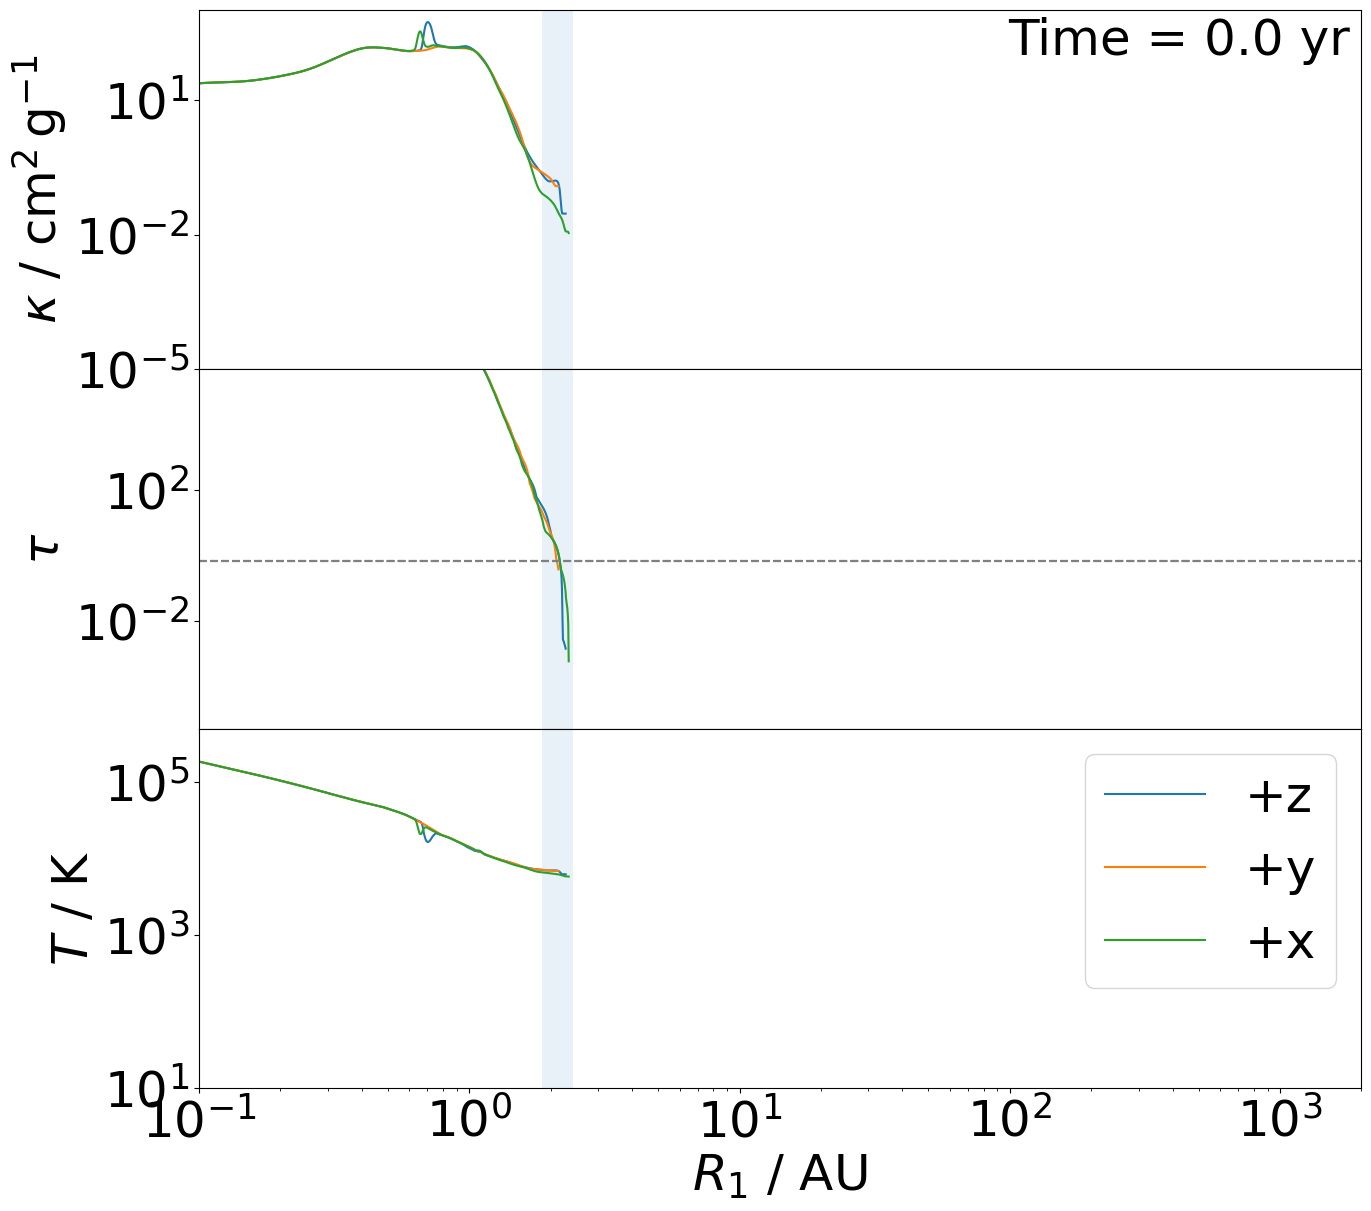

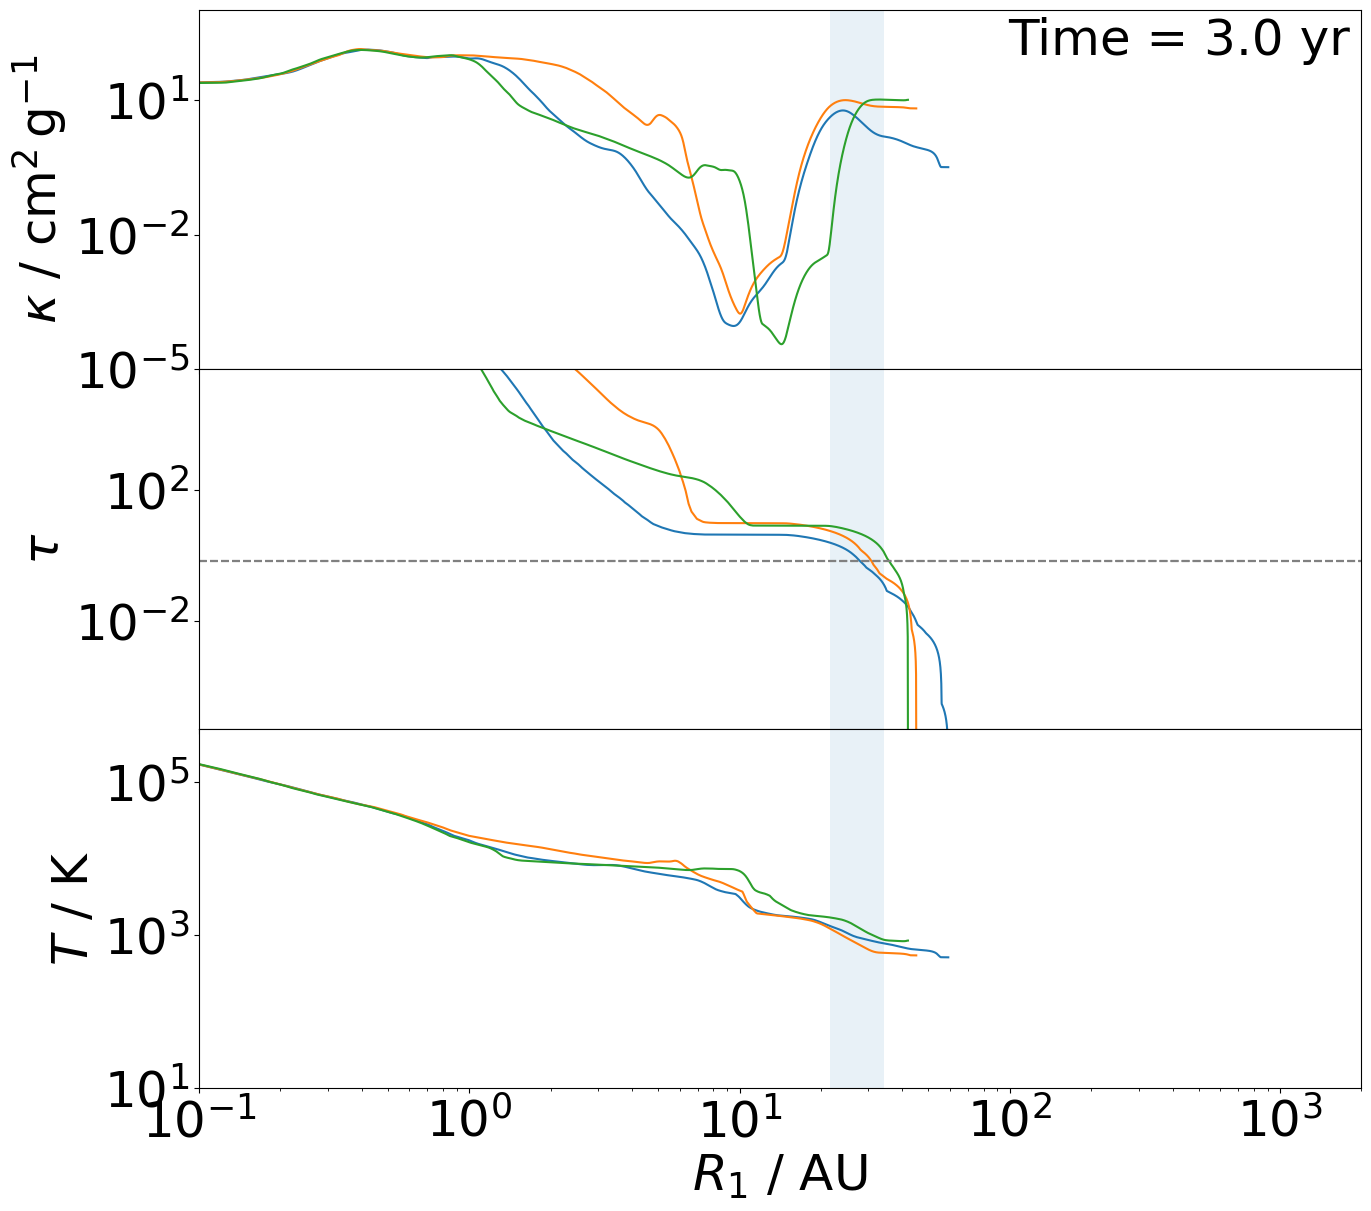

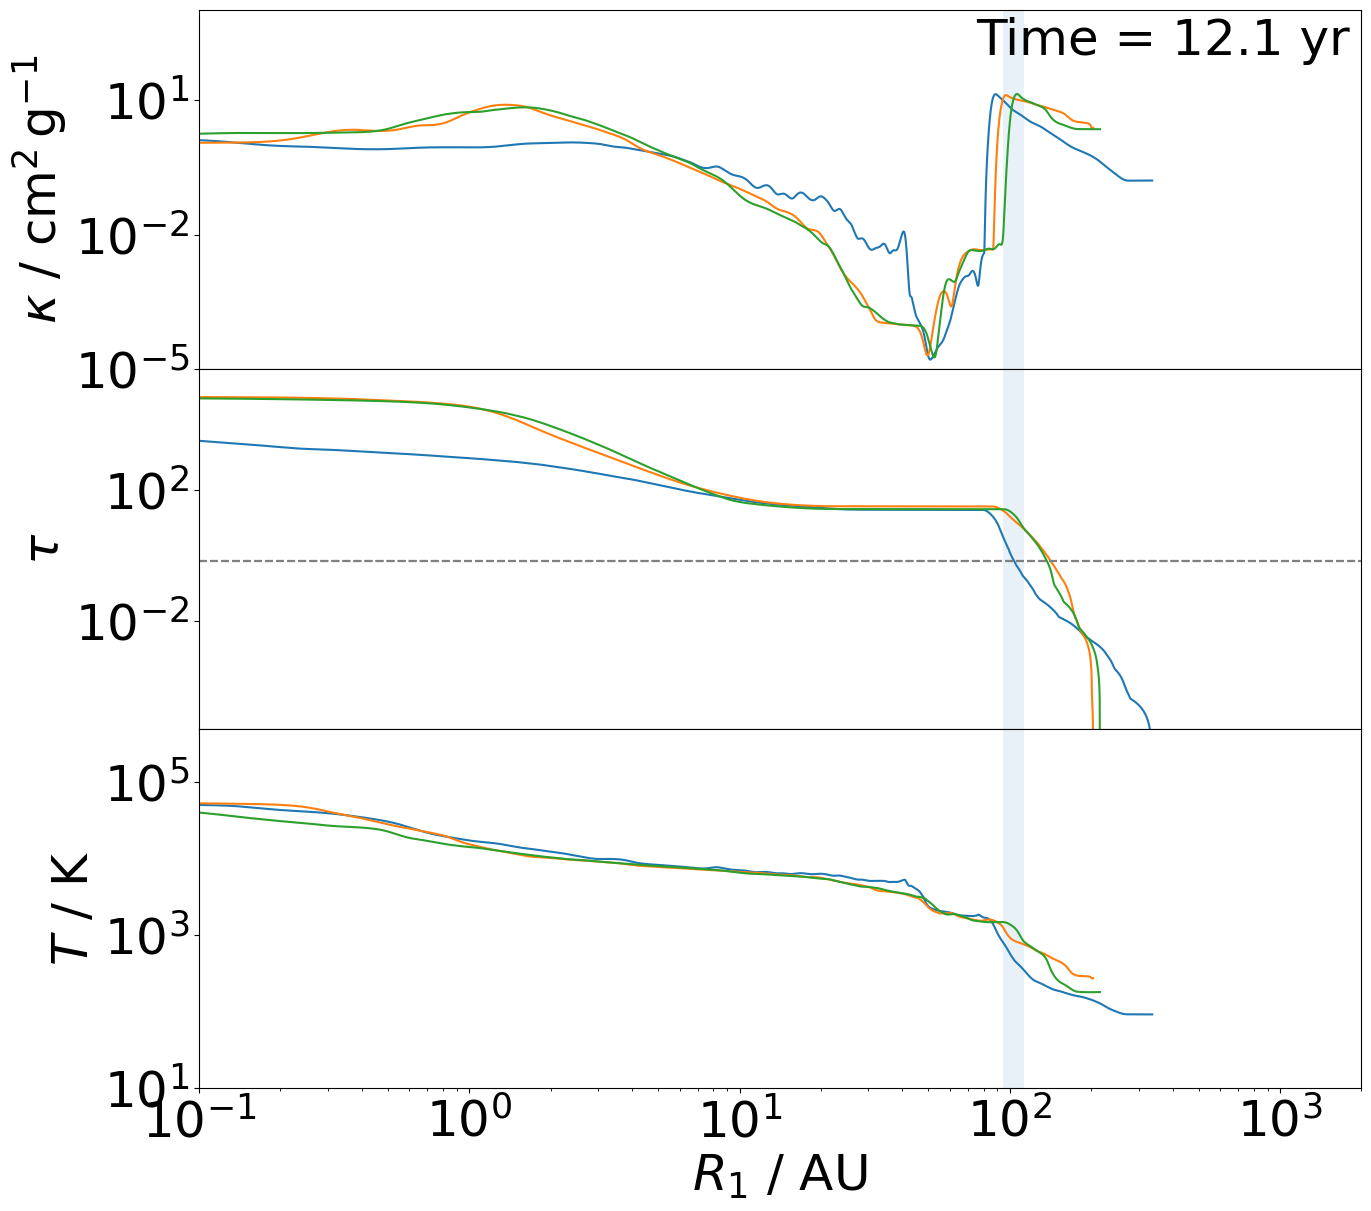

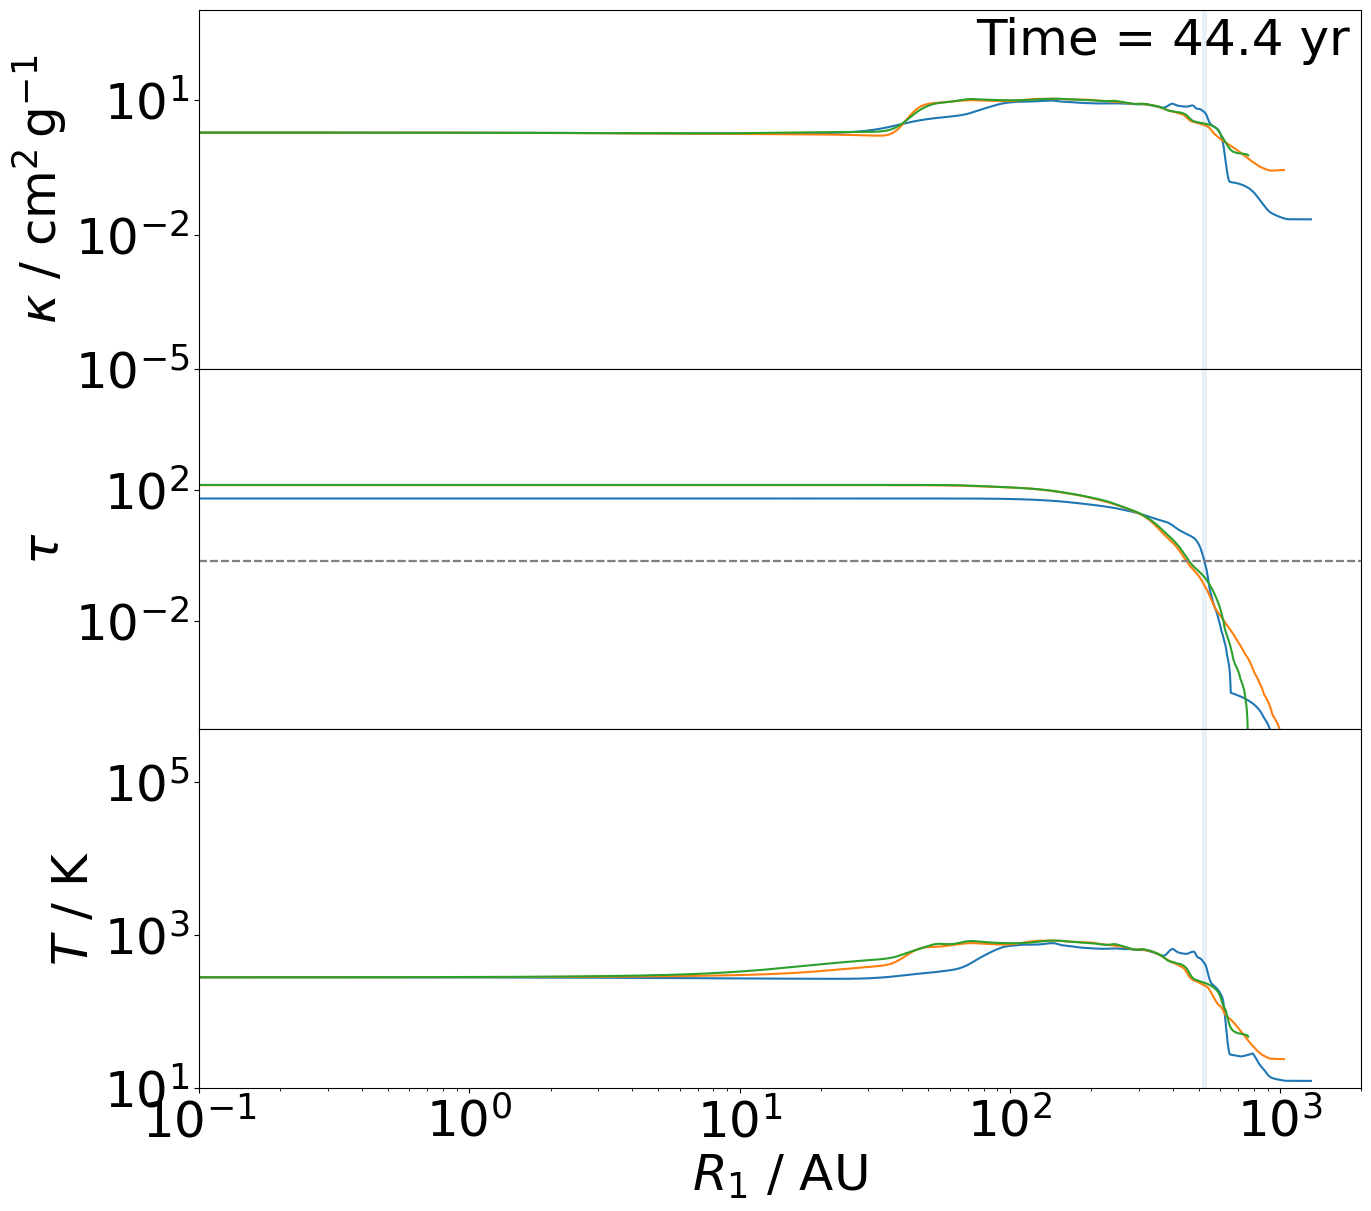

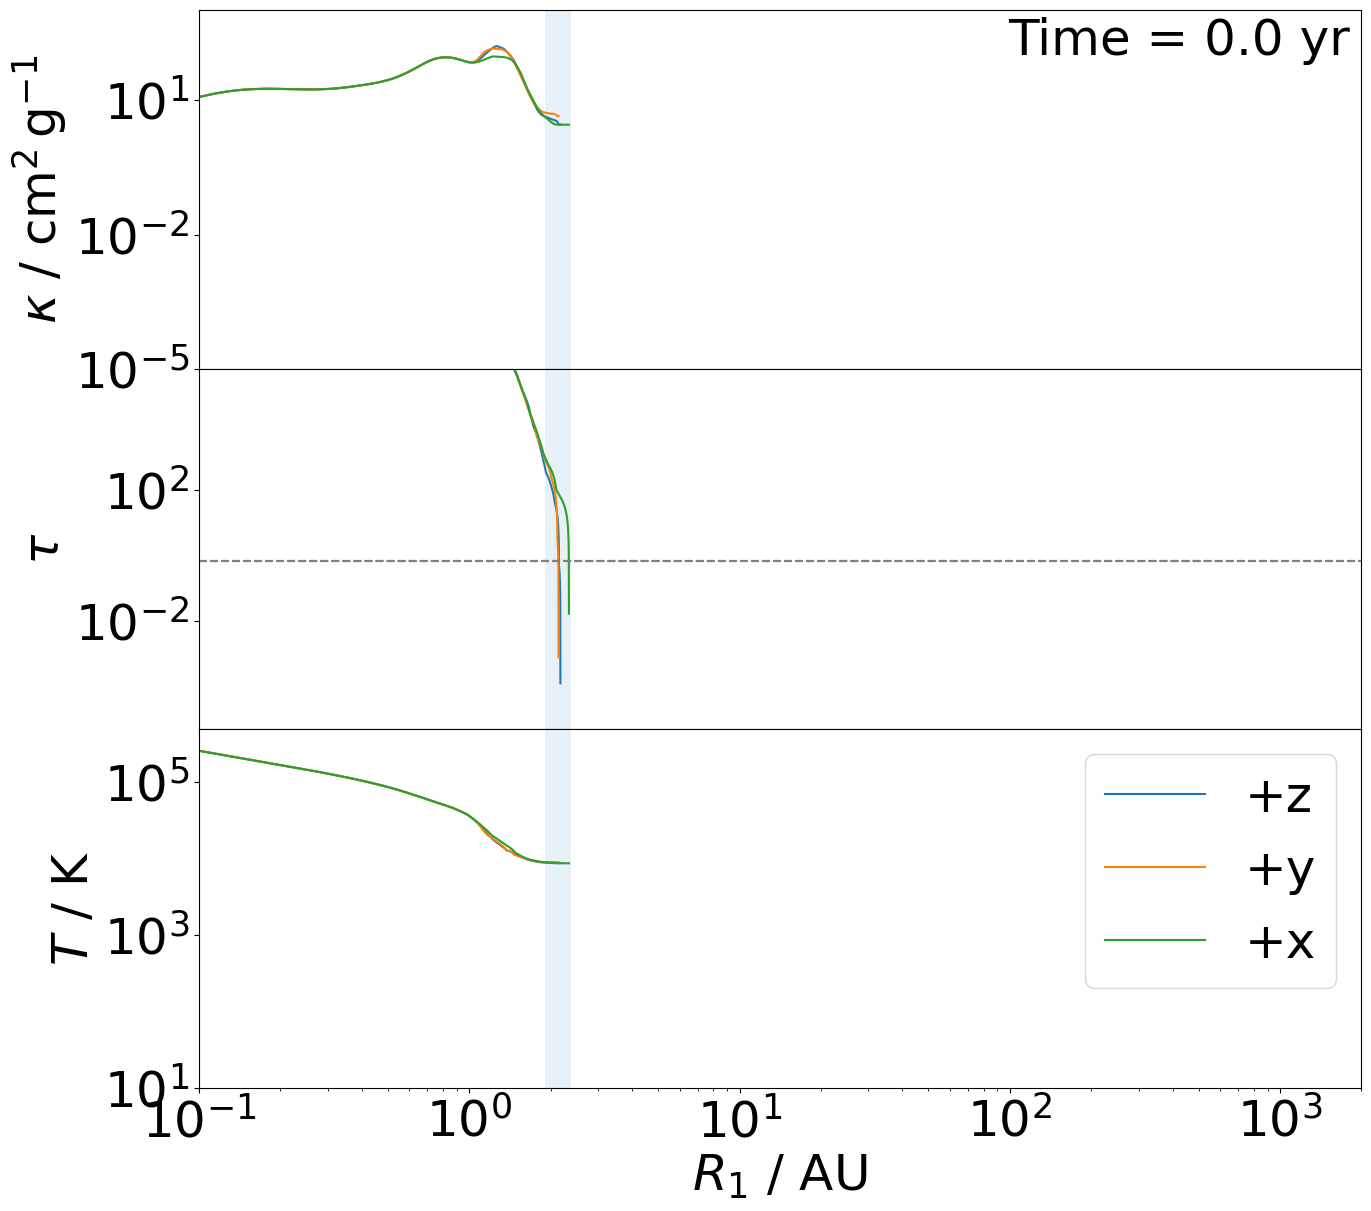

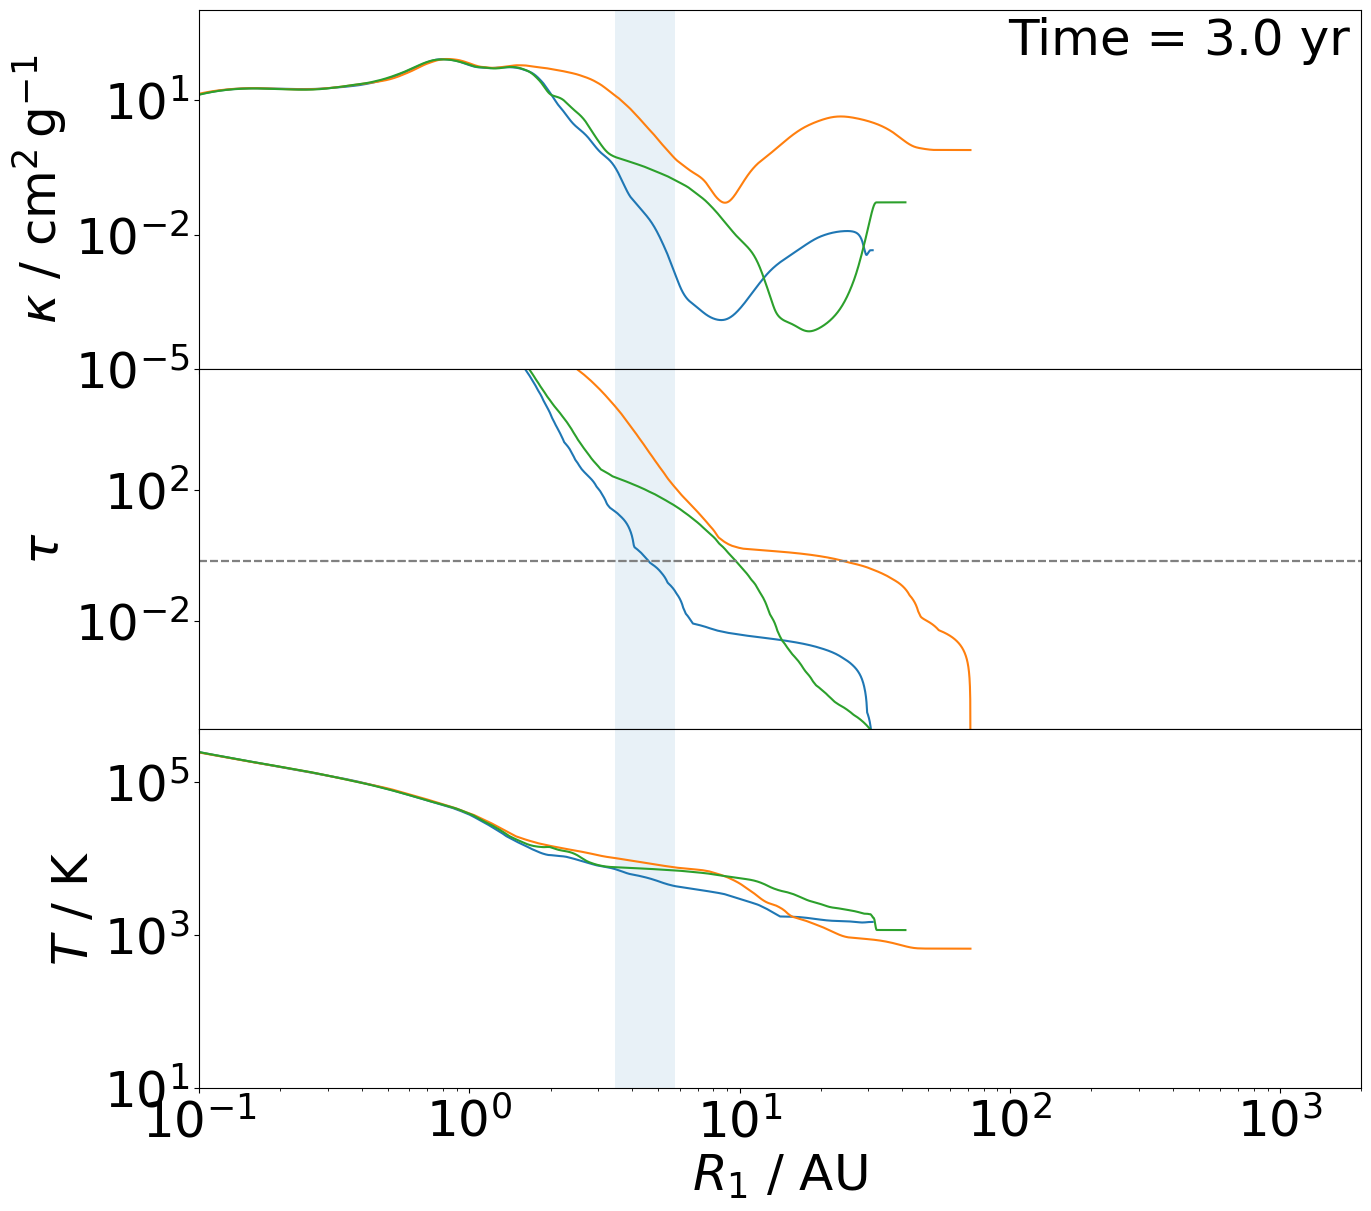

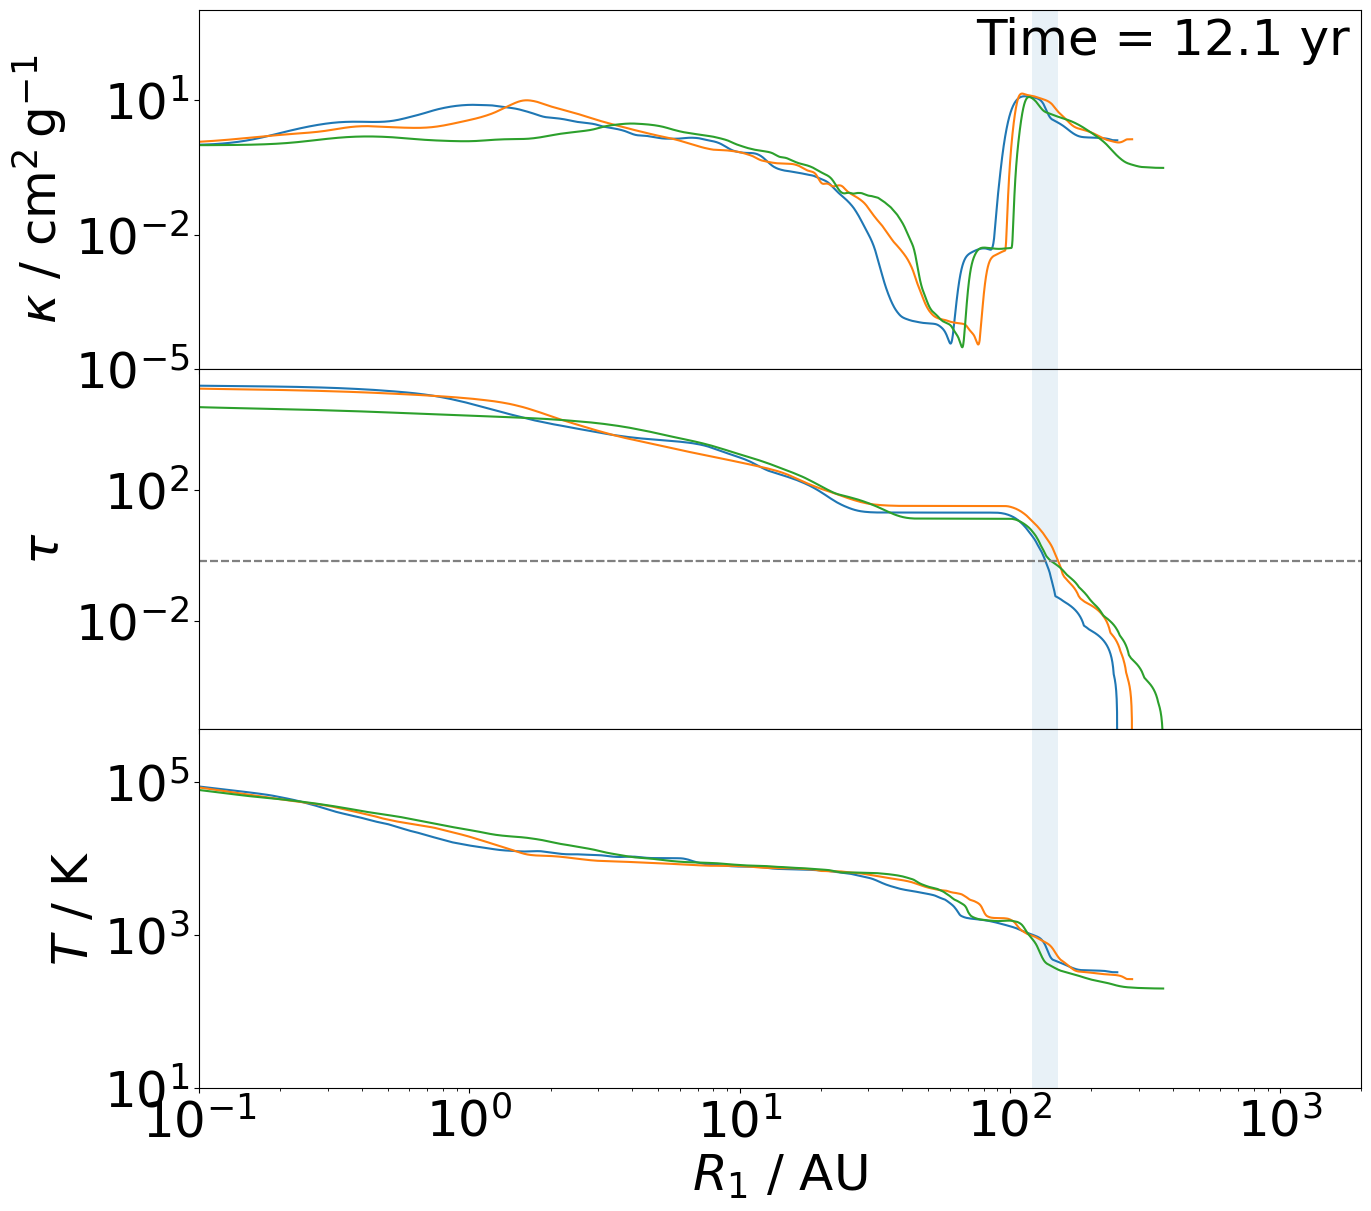

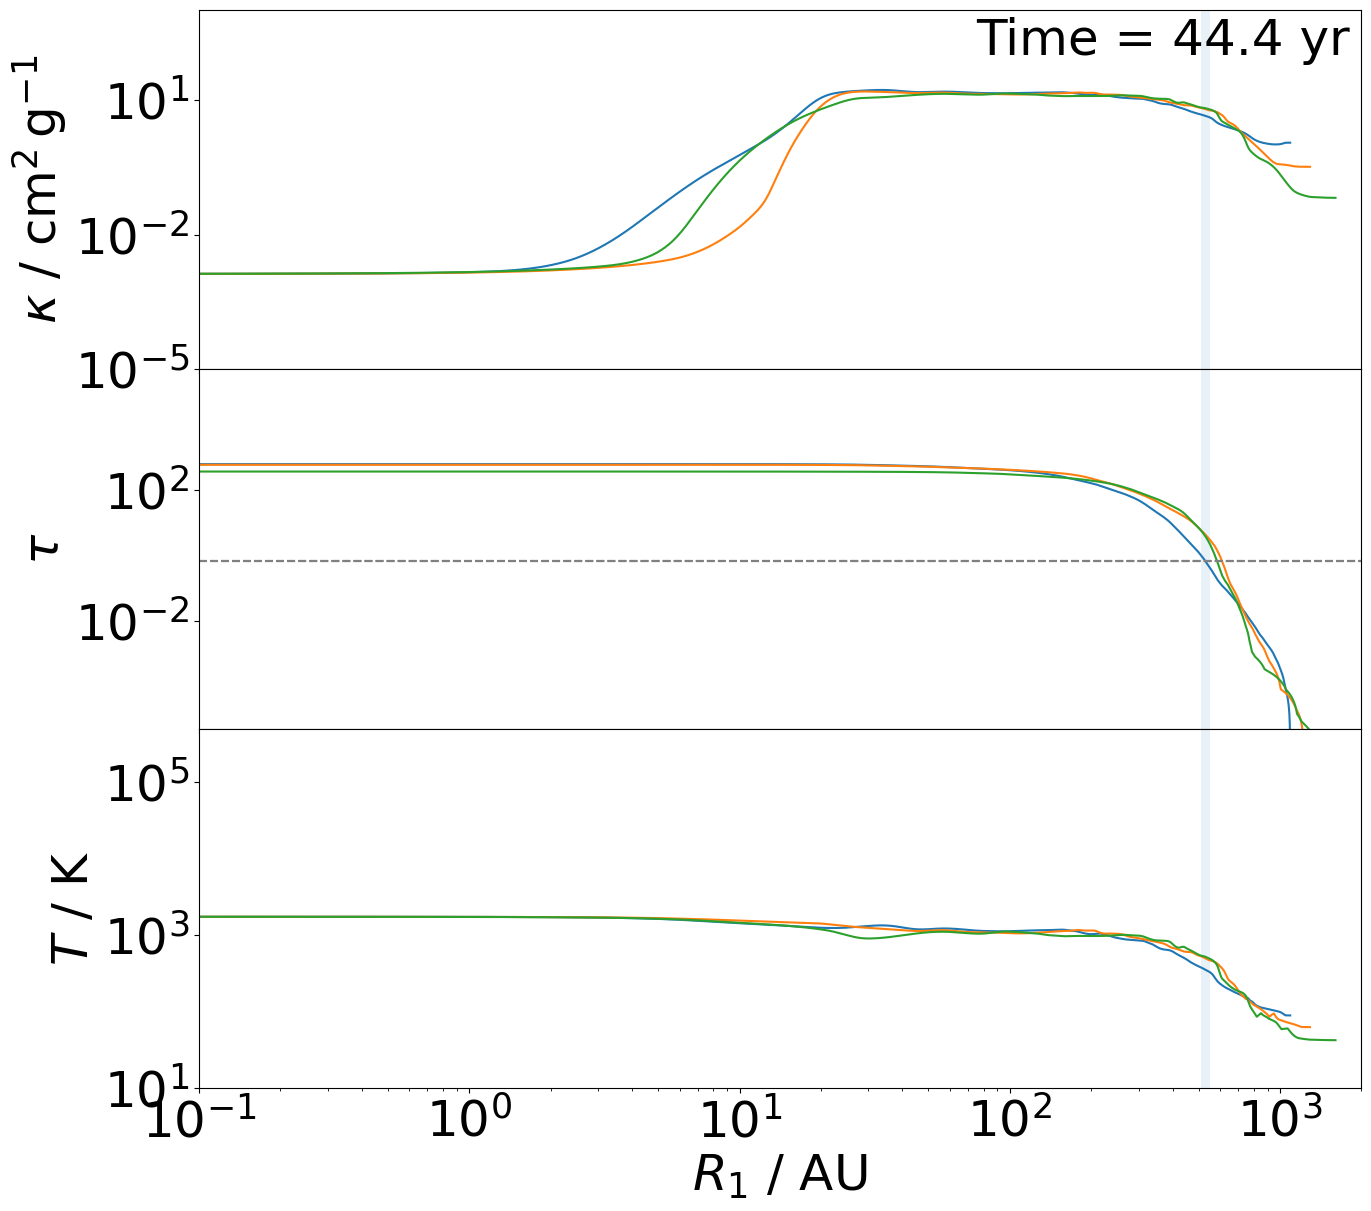

In [14]:
if __name__ == '__main__':
    plt.rcParams.update({'font.size': 36})
    
    xlim = (1e-1, 2e3)
    labels = ['+z', '+y', '+x']    # name of the ray to be plotted
    quans  = ['kappa', 'tau', 'T']    #, 'rho' # quantities to be plotted
    ylims  = {   # Note: you can supply (None, None)
        'tau': (5e-6, 5e5),
        'rho': (5e-20, 5e-6), # None
        'T'  : (1e1, 5e5),
        'kappa': (1e-5, 1e3),
        'vr' : (5e-1, 2e2),
    }
    ylabels = {
        'tau': "\\tau",
        'rho': "\\rho",
        'T'  : "T",
        'kappa': "\\kappa",
        'vr' : "{v_r}",
    }
    vals_txts : dict[str, dict[str, list]] = {quan: {} for quan in quans}
    vals_txts['R1'] = {}
    

    # plotting
    for nn in ['2md', '4md']:
        job_profile  = JOB_PROFILES_DICT[nn]
        job_name     = job_profile['job_name']
        job_nickname = job_profile['nickname']
        outfilenames = []
        for file_index in (0, 1200, 4800, 17600,):#(4800,): #job_profile['file_indexes'][:1]:
            # load data
            infilename = f"{interm_dir}{job_profile['nickname']}_{file_index:05}.photospherePars.xyz.json"
            if verbose: print(f"\nWorking on {infilename}...")
            with open(infilename, 'r') as f:
                photosphere_pars = json_load(f)
        
            time = set_as_quantity(photosphere_pars['time_yr'], units.yr)
            #orbsep_Rsun = np.array(photosphere_pars['orbsep_Rsun'])

        
            fig, axes = plt.subplots(len(quans), figsize=(15, 2+4*len(quans)), squeeze=False, sharex=True)
            fig.subplots_adjust(hspace=0.0, wspace=0.0)

            xerrs_dict = {}
            for i, label in enumerate(labels):
                photosphere = photosphere_pars['data'][label]
                xval  = get_val_in_unit(photosphere['R1'       ], unitsIn['dist'], unitsOut['dist'])
                xerr  = get_val_in_unit(photosphere['h'        ], unitsIn['dist'], unitsOut['dist'])
                xvals = get_val_in_unit(photosphere['R1_on_ray'], unitsIn['dist'], unitsOut['dist'])
                xerrs_dict[label] = (xval, xerr, xvals)
                
                
            for ax, quan in zip(axes, quans):
                ax = ax[0]
                ylim = ylims[quan] if quan in ylims.keys() else None
                ylabel = ylabels[quan] if quan in ylabels.keys() else None
                unit_name = get_units_field_name(quan)
                valtxts = []
                yvaltxt_logs = []
                yerrs_dict = {}
                
                for i, label in enumerate(labels):
                    photosphere = photosphere_pars['data'][label]
                    xval, xerr, xvals = xerrs_dict[label]
                    xerrp = xval + xerr
                    xerrm = xval - xerr

                    yvals = get_val_in_unit(photosphere[f'{quan}_on_ray'], unitsIn[unit_name], unitsOut[unit_name])
                    yval, yerrp, yerrm = get_yval_yerr(xval, xerrp, xerrm, xvals, yvals)
                    dyerrp = yerrp - yval
                    dyerrm = yerrm - yval
                    # store it for later because we want them to be on the same scale for +x and +z
                    yerrs_dict[label] = (yval, dyerrp, dyerrm)
                    
                    ax.loglog(xvals, yvals, color=f'C{i}', label=label)
                    ax.set_xlim(xlim)
                    ax.set_ylim(ylim)
                    if label in {'+z'}:
                        ax.fill_betweenx(
                            ax.get_ylim(),
                            get_val_in_unit(photosphere['R1'] - photosphere['h'], unitsIn['dist'], unitsOut['dist']),
                            get_val_in_unit(photosphere['R1'] + photosphere['h'], unitsIn['dist'], unitsOut['dist']),
                            color=f'C{i}', alpha=0.1, linewidth=0)
                    ax.set_ylabel(f"${ylabel}$ / {unitsOutTxt[unit_name]}" if unit_name != 'dimless' else f"${ylabel}$")
                    if quan == 'tau':
                        ax.axhline(PHOTOSPHERE_TAU, color='grey', linestyle='dashed')
                    if quan == 'vr':
                        ax.axhline(10., color='grey', linestyle='dashed')

                    # get the scale of the value for the exact val & err text
                    try:
                        yvaltxt_log = np.log10(np.abs([yval, dyerrm, dyerrp]))
                        yvaltxt_log = int(np.floor(np.average(yvaltxt_log[np.isfinite(yvaltxt_log)])))
                        if quan in ['tau','T']:
                            # mannual override
                            yvaltxt_log = 0
                    except ValueError:
                        yvaltxt_log = 0
                    yvaltxt_logs.append(yvaltxt_log)


                # get val text
                for label in labels:
                    # init
                    yvaltxt_log = min(yvaltxt_logs)
                    yval, dyerrp, dyerrm = yerrs_dict[label]
                    
                    # ignore small scales
                    if yvaltxt_log == 1:
                        yvaltxt_log = 0

                    yvaltxt_log = 0

                    if quan in {'T'}:
                        yvaltxt = f"${yval/10**yvaltxt_log:.0f}^{{{dyerrp/10**yvaltxt_log:+.0f}}}_{{{dyerrm/10**yvaltxt_log:+.0f}}}"
                    elif quan in {'tau'} or yval/10**yvaltxt_log < 0.2:
                        yvaltxt = f"${yval/10**yvaltxt_log:.2f}^{{{dyerrp/10**yvaltxt_log:+.2f}}}_{{{dyerrm/10**yvaltxt_log:+.2f}}}"
                    else:
                        yvaltxt = f"${yval/10**yvaltxt_log:.1f}^{{{dyerrp/10**yvaltxt_log:+.1f}}}_{{{dyerrm/10**yvaltxt_log:+.1f}}}"
                    if yvaltxt_log != 0: yvaltxt += f" \\times 10^{{{yvaltxt_log}}}"
                    yvaltxt += '$'
                    # yvaltxt += f" {unitsOutTxt[unit_name]}"
                    # yvaltxt = f"${ylabel}_\\mathrm{{ph, {label}}} =$ " + yvaltxt
                    # #yvaltxt += f" ({(abs(dyerrp)+abs(dyerrm))/yval/2:.0%})"

                    # print as latex
                    if label not in vals_txts[quan]:
                        vals_txts[quan][label] = [f"${ylabel}_\\mathrm{{ph, {label}}}$ / {unitsOutTxt[unit_name]}"]
                    vals_txts[quan][label].append(yvaltxt)
                    
                    # valtxts.append(yvaltxt)
                    
                # ax.text(xlim[0], ylim[0], '\n'.join(valtxts), ha='left', va='bottom')
                # print('\n', '\n'.join(valtxts), '\n')
            ax.set_xlabel(f"$R_1$ / {unitsOutTxt['dist']}")
            if file_index==0: ax.legend(loc='upper right')

            # set title and time label
            ax = axes[0][0]
            # ax_txts = []
            for label in labels:
                xval, xerr, _ = xerrs_dict[label]
                ax_txt = f"${xval:.0f} \\pm {xerr:.0f}$" if file_index else f"${xval:.1f} \\pm {xerr:.1f}$"
                # ax_txts.append(f"$R_{{1, \\mathrm{{ph, {label}}}}} =$ " + ax_txt)
                if label not in vals_txts['R1']:
                    vals_txts['R1'][label] = [f"$R_{{1, \\mathrm{{ph, {label}}}}}$ / {unitsOutTxt['dist']}"]
                vals_txts['R1'][label].append(ax_txt)

            ax.text(
                0.99, 0.98,
                f"Time = {time:.1f}",
                color = "black", ha = 'right', va = 'top',
                transform=ax.transAxes,
            )
            # ax.text(
            #     0.99, 0.02,
            #     '\n'.join(ax_txts),
            #     color = "black", ha = 'right', va = 'bottom',
            #     transform=ax.transAxes,
            # )
            # print('\n', '\n'.join(ax_txts), '\n')

            # save fig
            outfilename_noext = f"{output_dir}{job_nickname}_{file_index:05d}__singleRayProperties"
            for ext in ['png', 'pdf']:
                if ext == 'png':
                    ax.set_title(
                        f"Properties along one singe ray",# + \
                        #f"resolution = {photospheres['dump_info']['nparttot']:.2e}\n" + \
                        # f"{job_profile['plot_title_suffix']}",
                    )
                else:
                    ax.set_title('')
                outfilename = f"{outfilename_noext}.{ext}"
                fig.savefig(outfilename)
                if verbose: print(f"Saved to {outfilename}.")
                    
            outfilenames.append(outfilename)

    print('\n\n')
    txt = ''
    for quan in vals_txts:
        txt += ' \\\\[5pt]\n'.join([
            f"{' & '.join(vals_txts[quan][label])}"
            for label in vals_txts[quan]
        ]) + ' \\\\\\\\\n\n'
    print(txt, '\n\n')
    plt.show(fig)
    
    plt.rcParams.update({'font.size': 20})

In [13]:
help(ax.fill_betweenx)

Help on method fill_betweenx in module matplotlib.axes._axes:

fill_betweenx(
    y,
    x1,
    x2=0,
    where=None,
    step=None,
    interpolate=False,
    *,
    data=None,
    **kwargs
) method of matplotlib.axes._axes.Axes instance
    Fill the area between two vertical curves.

    The curves are defined by the points (*y*, *x1*) and (*y*,
    *x2*).  This creates one or multiple polygons describing the filled
    area.

    You may exclude some vertical sections from filling using *where*.

    By default, the edges connect the given points directly.  Use *step*
    if the filling should be a step function, i.e. constant in between
    *y*.

    Parameters
    ----------
    y : array-like
        The y coordinates of the nodes defining the curves.

    x1 : array-like or float
        The x coordinates of the nodes defining the first curve.

    x2 : array-like or float, default: 0
        The x coordinates of the nodes defining the second curve.

    where : array-like of b

## Debug

In [9]:
from lib.clmuphantomlib.settings import DEFAULT_SETTINGS
params = JOB_PROFILES[0]['params']
print(params, '\n', DEFAULT_SETTINGS)
opacs = mupl.eos_mesa.EoS_MESA_opacity(params=params, settings=DEFAULT_SETTINGS)

ModuleNotFoundError: No module named 'lib'

In [74]:
opacs.get_kappa(rho=1e-17, T=631)

0.8183562910657334

In [28]:
10**opacs._log10_T_arr

array([6.30957344e+02, 6.68343918e+02, 7.07945784e+02, 7.49894209e+02,
       7.94328235e+02, 8.41395142e+02, 8.91250938e+02, 9.44060876e+02,
       1.00000000e+03, 1.05925373e+03, 1.12201845e+03, 1.18850223e+03,
       1.25892541e+03, 1.33352143e+03, 1.41253754e+03, 1.49623566e+03,
       1.58489319e+03, 1.67880402e+03, 1.77827941e+03, 1.88364909e+03,
       1.99526231e+03, 2.11348904e+03, 2.23872114e+03, 2.37137371e+03,
       2.51188643e+03, 2.66072506e+03, 2.81838293e+03, 2.98538262e+03,
       3.16227766e+03, 3.34965439e+03, 3.54813389e+03, 3.75837404e+03,
       3.98107171e+03, 4.21696503e+03, 4.46683592e+03, 4.73151259e+03,
       5.01187234e+03, 5.30884444e+03, 5.62341325e+03, 5.95662144e+03,
       6.30957344e+03, 6.68343918e+03, 7.07945784e+03, 7.49894209e+03,
       7.94328235e+03, 8.41395142e+03, 8.91250938e+03, 9.44060876e+03,
       1.00000000e+04, 1.05925373e+04, 1.12201845e+04, 1.18850223e+04,
       1.25892541e+04, 1.33352143e+04, 1.41253754e+04, 1.49623566e+04,
      

In [11]:
# properties evolution with time plots

if __name__ == '__main__':

    # settings
    xlim = (0., 15.)
    labels = ['+x', '+z']    # name of the ray to be plotted
    quans  = ['T', 'rho', 'tau', 'kappa']    # quantities to be plotted
    ylims  = {   # Note: you can supply None
        'tau': (1e-2, 1e2),
        'rho': (1e-18, 1e-8), # None
        'T'  : (1e2, 5e4), #(1e2, 1e3),
        'kappa': None,
    }
    ylabels = {
        'tau': "\\tau",
        'rho': "\\rho",
        'T'  : "T",
        'kappa': "\\kappa",
    }
    

    # plotting
    # for job_profile in JOB_PROFILES:
    if True:
        job_profile = JOB_PROFILES_DICT['4md']
        job_name    = job_profile['job_name']
        outfilenames = []
        times  = []
        orbseps= []
        
        # # quans_dict[quan][ax] = (vals, dyerrps, dyerrms)
        # quans_dict = { quan: {label: ([], [], []) for label in labels} for quan in quans }
        for file_index in [2000]: #job_profile['file_indexes']:
            # load data
            jobfilename = mupl.get_filename_phantom_dumps(job_name, file_index)
            infilename_noext = f"{jobfilename}__photospherePars__xyz"
            #if verbose: print(f"\nWorking on {infilename_noext}... ", end='')
            with open(f"{infilename_noext}.json", 'r') as f:
                photosphere_pars = json_load(f)
        


In [12]:
photosphere_pars['data']['+x'].keys()

dict_keys(['is_found', 'loc', 'R1', 'rho', 'u', 'h', 'T', 'kappa', 'vr', 'size', 'R1_on_ray', 'tau_on_ray', 'rho_on_ray', 'u_on_ray', 'T_on_ray', 'kappa_on_ray', 'vr_on_ray'])

Text(0, 0.5, 'Contribution fraction')

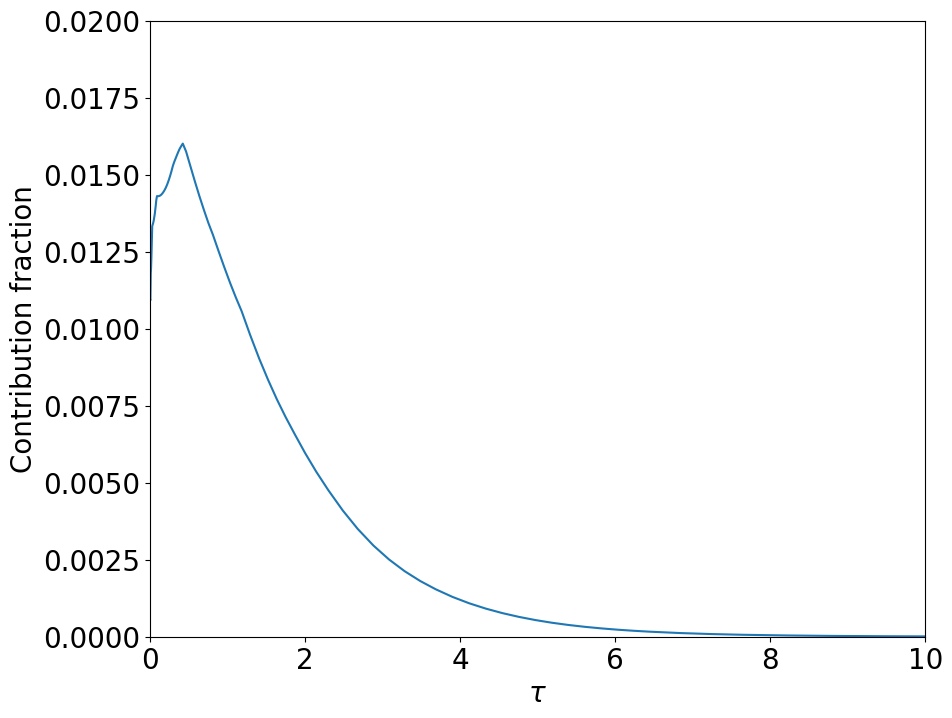

In [14]:
fig, ax = plt.subplots(figsize=(10, 8))
taus = photosphere_pars['data']['+x']['tau_on_ray']
Ts  = photosphere_pars['data']['+x']['T_on_ray']
contrs = Ts**4 * np.exp(-taus)
total = np.sum(contrs)
fracs = contrs / total
ax.plot(taus, fracs)

ax.set_xlim((0, 10))
ax.set_ylim((0, 0.02))
ax.set_xlabel("$\\tau$")
ax.set_ylabel("Contribution fraction")

## properties evolution with time plots

In [12]:
# properties evolution with time plots

if __name__ == '__main__':

    # settings
    xlim = (0., 15.)
    labels = ['+x', '+z']    # name of the ray to be plotted
    quans  = ['T', 'rho', 'tau', 'kappa']    # quantities to be plotted
    ylims  = {   # Note: you can supply None
        'tau': (1e-2, 1e2),
        'rho': (1e-18, 1e-8), # None
        'T'  : (1e2, 5e4), #(1e2, 1e3),
        'kappa': None,
    }
    ylabels = {
        'tau': "\\tau",
        'rho': "\\rho",
        'T'  : "T",
        'kappa': "\\kappa",
    }
    

    # plotting
    for job_profile in JOB_PROFILES:
        job_name    = job_profile['job_name']
        outfilenames = []
        times  = []
        orbseps= []
        # quans_dict[quan][ax] = (vals, dyerrps, dyerrms)
        quans_dict = { quan: {label: ([], [], []) for label in labels} for quan in quans }
        for file_index in job_profile['file_indexes']:
            # load data
            jobfilename = mupl.get_filename_phantom_dumps(job_name, file_index)
            infilename_noext = f"{jobfilename}__photospherePars__xyz"
            #if verbose: print(f"\nWorking on {infilename_noext}... ", end='')
            with open(f"{infilename_noext}.json", 'r') as f:
                photosphere_pars = json_load(f)
        
            times.append(  get_val_in_unit(photosphere_pars['time_yr'    ], units.yr,   unitsOut['time']))
            orbseps.append(get_val_in_unit(photosphere_pars['orbsep_Rsun'], units.Rsun, unitsOut['dist']))

            xerrs_dict = {}
            for i, label in enumerate(labels):
                photosphere = photosphere_pars['data'][label]
                xval  = get_val_in_unit(photosphere['R1'       ], unitsIn['dist'], unitsOut['dist'])
                xerr  = get_val_in_unit(photosphere['h'        ], unitsIn['dist'], unitsOut['dist'])
                xvals = get_val_in_unit(photosphere['R1_on_ray'], unitsIn['dist'], unitsOut['dist'])
                xerrs_dict[label] = (xval, xerr, xvals)
                
                
            for quan in quans:
                valtxts = []
                yerrs_dict = {}
                unit_name = get_units_field_name(quan)
                for i, label in enumerate(labels):
                    photosphere = photosphere_pars['data'][label]
                    xval, xerr, xvals = xerrs_dict[label]
                    xerrp = xval + xerr
                    xerrm = xval - xerr
                    yvals = get_val_in_unit(photosphere[f'{quan}_on_ray'], unitsIn[unit_name], unitsOut[unit_name])
                    yval, yerrp, yerrm = get_yval_yerr(xval, xerrp, xerrm, xvals, yvals)
                    dyerrp = yerrp - yval
                    dyerrm = yerrm - yval
                    quans_dict[quan][label][0].append(yval)
                    quans_dict[quan][label][1].append(dyerrp)
                    quans_dict[quan][label][2].append(dyerrm)

        times   = np.array(times)
        orbseps = np.array(orbseps)
        # plotting
        for quan in quans:
            unit_name = get_units_field_name(quan)
            ylabel = ylabels[quan]
            fig, ax = plt.subplots(figsize=(10, 8))
            fig.subplots_adjust(left=0.15, top=0.8)


            for i, label in enumerate(labels):
                x = times
                y      = np.array(quans_dict[quan][label][0])
                dyerrp = np.array(quans_dict[quan][label][1])
                dyerrm = np.array(quans_dict[quan][label][2])
                ax.semilogy(x, y, '-', color=f'C{i}', label=label)    
                ax.fill_between(x, y+dyerrp, y+dyerrm, color=f'C{i}', alpha=0.15)

            ax.set_xlim(xlim)
            ax.set_ylim(ylims[quan])
            ax.set_xlabel("Time / year")
            ax.set_ylabel(f"${ylabel}$ / {unitsOutTxt[unit_name]}" if unit_name != 'dimless' else f"${ylabel}$")
            ax.legend(loc='lower left')


            # getting funcs for 2nd x axis transform, and
            # making sure orbseps is mono-decreasing, so np.interp doesn't freak out
            orbsep_tempmin = orbseps[0]
            x_inds = [0]
            for i in range(len(orbseps)):
                if orbsep_tempmin > orbseps[i]:
                    orbsep_tempmin = orbseps[i]
                    x_inds.append(i)
            times_inds   = times[x_inds].copy()
            orbseps_inds = orbseps[x_inds].copy()
            if xlim[1] > times_inds[-1]:
                # add an end point so the secondary xaxis labels of orbsep does not freak out
                times_inds   = np.append(times_inds, xlim[1])
                orbseps_inds = np.append(orbseps_inds, orbseps_inds[-1]*(1.-1e-5))
            functions = (
                lambda x: np.interp(x, times_inds, orbseps_inds),
                lambda x: np.interp(x, orbseps_inds[::-1], times_inds[::-1]),
            )
            secax = ax.secondary_xaxis('top', functions=functions)
            secax.set_xlabel(f"Separation (Dusty) / {unitsOutTxt['dist']}")
            secax.set_ticks(functions[0](ax.get_xticks()[:-1]))
            
            # save fig
            # define job_folder_prefix
            for i in range(len(job_name)-1, -1, -1):
                if job_name[i] == path.sep:
                    job_folder_prefix = job_name[:i]
                    break
                else:
                    job_folder_prefix = job_name
            outfilename_noext = f"{job_folder_prefix}__singleRayEvo-{quan}"
            for ext in ['png', 'pdf']:
                if ext == 'png':
                    ax.set_title(
                        f"Evolution of photospheric ${ylabel}$ for one singe ray\n" + \
                        #f"resolution = {photospheres['dump_info']['nparttot']:.2e}\n" + \
                        f"{job_profile['plot_title_suffix']}",
                    )
                else:
                    ax.set_title('')
                outfilename = f"{outfilename_noext}.{ext}"
                fig.savefig(outfilename)
                if verbose: print(f"Saved to {outfilename}.")
            plt.close(fig)

    if verbose: print("\n\n\n*** All Done. ***\n\n\n")

Saved to ../photosphere/luis_2md__singleRayEvo-T.png.
Saved to ../photosphere/luis_2md__singleRayEvo-T.pdf.
Saved to ../photosphere/luis_2md__singleRayEvo-rho.png.
Saved to ../photosphere/luis_2md__singleRayEvo-rho.pdf.
Saved to ../photosphere/luis_2md__singleRayEvo-tau.png.
Saved to ../photosphere/luis_2md__singleRayEvo-tau.pdf.
Saved to ../photosphere/luis_2md__singleRayEvo-kappa.png.
Saved to ../photosphere/luis_2md__singleRayEvo-kappa.pdf.


FileNotFoundError: [Errno 2] No such file or directory: '../photosphere/luis_4md/light_00000__photospherePars__xyz.json'

## properties error percentage evolution with time plots

In [21]:
# properties error percentage evolution with time plots

if __name__ == '__main__':

    # settings
    xlim = (0., 44.)
    labels = ['+x', '+z']    # name of the ray to be plotted
    quans  = ['T', 'rho', 'tau']    # quantities to be plotted
    ylims  = {   # Note: you can supply None
        'tau': (0, 300),
        'rho': (0, 500), # None
        'T'  : (0, 100),
    }
    ylabels = {
        'tau': "\\tau",
        'rho': "\\rho",
        'T'  : "T",
    }
    

    # plotting
    for job_profile in JOB_PROFILES:
        job_name    = job_profile['job_name']
        outfilenames = []
        times  = []
        orbseps= []
        # quans_dict[quan][ax] = (vals, dyerrps, dyerrms)
        quans_dict = { quan: {label: ([], [], []) for label in labels} for quan in quans }
        for file_index in job_profile['file_indexes']:
            # load data
            jobfilename = mupl.get_filename_phantom_dumps(job_name, file_index)
            outfilename_noext = f"{jobfilename}__photospherePars__xyz"
            #if verbose: print(f"\nWorking on {outfilename_noext}... ", end='')
            with open(f"{outfilename_noext}.json", 'r') as f:
                photosphere_pars = json_load(f)
        
            times.append(get_val_in_unit(photosphere_pars['time_yr'], units.yr, unitsOut['time']))
            orbseps.append(get_val_in_unit(photosphere_pars['orbsep_Rsun'], units.Rsun, unitsOut['dist']))

            xerrs_dict = {}
            for i, label in enumerate(labels):
                photosphere = photosphere_pars['data'][label]
                xval  = get_val_in_unit(photosphere['R1'       ], unitsIn['dist'], unitsOut['dist'])
                xerr  = get_val_in_unit(photosphere['h'        ], unitsIn['dist'], unitsOut['dist'])
                xvals = get_val_in_unit(photosphere['R1_on_ray'], unitsIn['dist'], unitsOut['dist'])
                xerrs_dict[label] = (xval, xerr, xvals)
                
                
            for quan in quans:
                valtxts = []
                yerrs_dict = {}
                for i, label in enumerate(labels):
                    photosphere = photosphere_pars['data'][label]
                    xval, xerr, xvals = xerrs_dict[label]
                    xerrp = xval + xerr
                    xerrm = xval - xerr

                    yvals = get_val_in_unit(photosphere[f'{quan}_on_ray'], unitsIn[unit_name], unitsOut[unit_name])
                    yval, yerrp, yerrm = get_yval_yerr(xval, xerrp, xerrm, xvals, yvals)
                    dyerrp = yerrp - yval
                    dyerrm = yerrm - yval
                    quans_dict[quan][label][0].append(yval)
                    quans_dict[quan][label][1].append(dyerrp)
                    quans_dict[quan][label][2].append(dyerrm)

        times   = np.array(times)
        orbseps = np.array(orbseps)
        # plotting
        for quan in quans:
            unit_name = get_units_field_name(quan)
            ylabel = ylabels[quan]
            fig, ax = plt.subplots(figsize=(10, 8))
            fig.subplots_adjust(left=0.15, top=0.8)
            ax.set_title(
                f"Relative uncetainty on photospheric ${ylabel}$ at one singe ray\n" + \
                #f"resolution = {photospheres['dump_info']['nparttot']:.2e}\n" + \
                f"{job_profile['plot_title_suffix']}",
            )


            for i, label in enumerate(labels):
                x = times
                yvals  = np.array(quans_dict[quan][label][0])
                dyerrp = np.array(quans_dict[quan][label][1])
                dyerrm = np.array(quans_dict[quan][label][2])
                y = (np.abs(dyerrp)+np.abs(dyerrm)) / np.abs(yvals) / 2
                ax.scatter(x, y*100, color=f'C{i}', label=label)

            ax.set_xlim(xlim)
            ax.set_ylim(ylims[quan])
            ax.set_xlabel("Time / year")
            ax.set_ylabel(f"$ \\Delta {ylabel} / {ylabel}$ / $\\%$")
            ax.legend(loc='upper right')


            # getting funcs for 2nd x axis transform, and
            # making sure orbseps is mono-decreasing, so np.interp doesn't freak out
            orbsep_tempmin = orbseps[0]
            x_inds = [0]
            for i in range(len(orbseps)):
                if orbsep_tempmin > orbseps[i]:
                    orbsep_tempmin = orbseps[i]
                    x_inds.append(i)
            times_inds   = times[x_inds].copy()
            orbseps_inds = orbseps[x_inds].copy()
            if xlim[1] > times_inds[-1]:
                # add an end point so the secondary xaxis labels of orbsep does not freak out
                times_inds   = np.append(times_inds, xlim[1])
                orbseps_inds = np.append(orbseps_inds, orbseps_inds[-1]*(1.-1e-5))
            functions = (
                lambda x: np.interp(x, times_inds, orbseps_inds),
                lambda x: np.interp(x, orbseps_inds[::-1], times_inds[::-1]),
            )
            secax = ax.secondary_xaxis('top', functions=functions)
            secax.set_xlabel(f"Separation (Dusty) / {unitsOutTxt['dist']}")
            secax.set_ticks(functions[0](ax.get_xticks()[:-1]))
            
            # save fig
            # define job_folder_prefix
            for i in range(len(job_name)-1, -1, -1):
                if job_name[i] == path.sep:
                    job_folder_prefix = job_name[:i]
                    break
                else:
                    job_folder_prefix = job_name
            outfilename = f"{job_folder_prefix}__singleRayErrPct-{quan}.png"
            fig.savefig(outfilename)
            plt.close(fig)

    if verbose: print("\n\n\n*** All Done. ***\n\n\n")




*** All Done. ***



